## This project focuses on implementing machine learning in credit risk predictions. Detail description will be updated shortly.

# PD model

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Import Data

In [26]:
loan_data_backup = pd.read_csv('loan_data.csv')

C:\Users\YizhiZhang\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
loan_data = loan_data_backup.copy()

In [28]:
pd.options.display.max_columns = None

In [29]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [31]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# General Processing

## Preprocessing few continuous variables

### Turn 'emp_length' to float

In [32]:
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [33]:
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a', str(0))

C:\Users\YizhiZhang\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [34]:
loan_data['emp_length_int'].head(10)

0    10
1     0
2    10
3    10
4     1
5     3
6     8
7     9
8     4
9     0
Name: emp_length_int, dtype: object

In [35]:
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])

In [36]:
type(loan_data['emp_length_int'][0])

numpy.float64

In [37]:
loan_data['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7., nan])

In [38]:
loan_data['emp_length_int'].isnull().sum()

21008

### Turn 'term' into int

In [39]:
loan_data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [40]:
loan_data['term_int'] = loan_data['term'].str.split(expand=True)[0]

In [41]:
loan_data['term_int'] = pd.to_numeric(loan_data['term_int'])

In [42]:
loan_data['term_int'].unique()

array([36, 60], dtype=int64)

### Turn 'earliest_cr_line' and '' into months since

In [43]:
loan_data['earliest_cr_line'].head()

0    Jan-85
1    Apr-99
2    Nov-01
3    Feb-96
4    Jan-96
Name: earliest_cr_line, dtype: object

In [44]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')

In [45]:
loan_data['earliest_cr_line_date'].head()

0   1985-01-01
1   1999-04-01
2   2001-11-01
3   1996-02-01
4   1996-01-01
Name: earliest_cr_line_date, dtype: datetime64[ns]

In [46]:
# date = pd.datetime.today()
date = pd.to_datetime('2017-12-01')

In [47]:
date - loan_data['earliest_cr_line_date'].head()

0   12022 days
1    6819 days
2    5874 days
3    7974 days
4    8005 days
Name: earliest_cr_line_date, dtype: timedelta64[ns]

In [48]:
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((date - loan_data['earliest_cr_line_date']) / np.timedelta64(1,'M')))

In [49]:
loan_data['mths_since_earliest_cr_line'].describe()

count    466256.000000
mean        239.482430
std          93.974829
min        -612.000000
25%         183.000000
50%         225.000000
75%         285.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [50]:
loan_data.loc[:,['earliest_cr_line','earliest_cr_line_date','mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line']<0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-537.0
1770,Sep-68,2068-09-01,-609.0
2799,Sep-64,2064-09-01,-561.0
3282,Sep-67,2067-09-01,-597.0
3359,Feb-65,2065-02-01,-566.0
...,...,...,...
464003,Jan-68,2068-01-01,-601.0
464260,Jul-66,2066-07-01,-583.0
465100,Oct-67,2067-10-01,-598.0
465500,Sep-67,2067-09-01,-597.0


In [51]:
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line']<0] = loan_data['mths_since_earliest_cr_line'].max() 

C:\Users\YizhiZhang\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
min(loan_data['mths_since_earliest_cr_line'])

73.0

### Turn 'issue_d' and '' into timestamp

In this homework, your task is to preprocess the ‘term’ variable and the ‘issue_d’ variable, similarly to the ‘employment length’ variable and the ‘earliest credit line variable’ we preprocessed in the last lecture. 1. From the variable ‘term’, which is of object (text string) data type, create a new variable, named ‘term_int’, which is numeric and contains the term of the loan in months. Tips: First remove the unnecessary text from each row; then, turn what remains into a numeric variable. 2. From the variable ‘issue date’ (‘issue_d’), which is of object (text string) data type, create a new variable, named ‘mths_since_issue_d’ (‘months since issue date’). Tips: First turn the test strings into dates; then calculate the difference between December 1st 2017 and each of the issue dates, in months; finally, check if the values make sense.

In [53]:
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y')

In [54]:
date - pd.to_datetime(loan_data['issue_d'], format='%b-%y')

0        2192 days
1        2192 days
2        2192 days
3        2192 days
4        2192 days
            ...   
466280   1430 days
466281   1430 days
466282   1430 days
466283   1430 days
466284   1430 days
Name: issue_d, Length: 466285, dtype: timedelta64[ns]

In [55]:
loan_data['mths_since_issue_d'] = round(pd.to_numeric((date - loan_data['issue_d_date']) / np.timedelta64(1,'M')))

In [56]:
loan_data['mths_since_issue_d'].unique()

array([ 72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.])

In [57]:
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

### Dummy discrete variables

In [58]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [59]:
loan_data['grade'].head()

0    B
1    C
2    C
3    C
4    B
Name: grade, dtype: object

In [60]:
loan_data_dummies = pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep=':')

In [61]:
loan_data_dummies = [
    pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep=':'),
    pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep=':'),
    pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep=':'),
    pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep=':'),
    pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep=':'),
    pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep=':'),
    pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep=':'),
    pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep=':')
]

In [62]:
loan_data_dummies = pd.concat(loan_data_dummies, axis=1)

In [63]:
type(loan_data_dummies)

pandas.core.frame.DataFrame

In [64]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis=1)

In [65]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [66]:
pd.options.display.max_rows = 100

In [67]:
loan_data.isnull().sum().values

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,  27588,  21008,      0,      4,      0,
            0,      0,      0,      0, 340302,      0,     20,      0,
            0,      0,     29,     29,     29, 250351, 403647,     29,
           29,      0,    340,     29,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,    376,      0,
       227214,     42,    145, 367311,      0,      0, 466285, 466285,
       466285,     29,  70276,  70276, 466285, 466285, 466285, 466285,
       466285, 466285, 466285, 466285, 466285, 466285, 466285,  70276,
       466285, 466285, 466285,  21008,      0,     29,     29,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [68]:
loan_data.isnull().sum() /loan_data.shape[0]

Unnamed: 0               0.0
id                       0.0
member_id                0.0
loan_amnt                0.0
funded_amnt              0.0
                        ... 
addr_state:WI            0.0
addr_state:WV            0.0
addr_state:WY            0.0
initial_list_status:f    0.0
initial_list_status:w    0.0
Length: 207, dtype: float64

In [69]:
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace = True)

In [70]:
loan_data['total_rev_hi_lim'].isnull().sum()

0

In this homework, your task is to fill in the missing values for the remaining variables we are going to use in our models. Here are the instructions about what values to replace the missing values with for the remaining variables. 1. For annual income (‘annual_inc’), replace the missing values with the mean of the non-missing values of the variable. 2. For all of the following variables, replace the missing values with zeroes: ‘mths_since_earliest_cr_line’ ‘acc_now_delinq’ ‘total_acc’ ‘pub_rec’ ‘open_acc’ ‘inq_last_6mths’ ‘delinq_2yrs’ ‘emp_length_int’

In [71]:
loan_data['annual_inc'].isnull().sum()

4

In [72]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)

In [73]:
loan_data['annual_inc'].isnull().sum()

0

In [74]:
loan_data.update(loan_data[['mths_since_earliest_cr_line', 'acc_now_delinq', 'total_acc','pub_rec','open_acc','inq_last_6mths','delinq_2yrs','emp_length_int']].fillna(0))

In [75]:
loan_data[['mths_since_earliest_cr_line', 'acc_now_delinq', 'total_acc','pub_rec','open_acc','inq_last_6mths','delinq_2yrs','emp_length_int']].isnull().sum()

mths_since_earliest_cr_line    0
acc_now_delinq                 0
total_acc                      0
pub_rec                        0
open_acc                       0
inq_last_6mths                 0
delinq_2yrs                    0
emp_length_int                 0
dtype: int64

create good/bad definition

In [76]:
loan_data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [77]:
loan_data['loan_status'].value_counts()/loan_data['loan_status'].count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [78]:
loan_data['good_bad'] =np.where(loan_data['loan_status'].isin(['Charged Off','Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)']),0,1)

In [79]:
loan_data['good_bad'].unique()

array([1, 0])

Independent Variables into dummies according to **WoE**

fine classing -> WoE calculation -> Coarse classing

# $\text{WoE}_{i}=\ln \left(\frac{\%(y=1)_i}{\%(y=0)_i}\right)$

Information Value (IF)

# $\text{IF} = \sum_{i=1}^{k}\left[\left(\%(y=1)_i-\%(y=0)_i\right)\right]\times\text{WoE_i}$
Suppose there are k categories for this variable. Either continuous after classing or discrete.

More advanced methods: classing with WoE and sample size. abnormal values goes to the two side classes.

# splitting data

In [80]:
X_train, X_test, y_train, y_test = train_test_split(loan_data.drop('good_bad',axis=1), loan_data['good_bad'], test_size=0.2, random_state=42)

In [81]:
X_train.shape

(373028, 207)

In [82]:
y_train.shape

(373028,)

In [83]:
X_test.shape

(93257, 207)

In [84]:
y_test.shape

(93257,)

In [239]:
#df_inputs_pre = X_train
#df_targets_pre = y_train
df_inputs_pre = X_test
df_targets_pre = y_test

In [240]:
df_inputs_pre['grade'].unique()

array(['C', 'E', 'A', 'D', 'B', 'F', 'G'], dtype=object)

In [241]:
df1 = pd.concat([df_inputs_pre['grade'], df_targets_pre],axis=1)
df1.head()

,grade,good_bad
362514,C,1
288564,E,1
213591,C,1
263083,C,1
165001,A,1


In [242]:
df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].count()

,grade,good_bad
0,A,15108
1,B,27199
2,C,25048
3,D,15390
4,E,7145
5,F,2699
6,G,668


In [243]:
df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].mean()

,grade,good_bad
0,A,0.962338
1,B,0.923085
2,C,0.882905
3,D,0.844314
4,E,0.805178
5,F,0.775472
6,G,0.697605


In [244]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].count(),
                df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].mean()], axis=1)

In [245]:
df1.head()

,grade,good_bad,grade,good_bad
0,A,15108,A,0.962338
1,B,27199,B,0.923085
2,C,25048,C,0.882905
3,D,15390,D,0.844314
4,E,7145,E,0.805178


In [246]:
df1 = df1.iloc[:,[0,1,3]]
df1.columns = [df1.columns.values[0], 'n_obs', 'prop_good']

In [247]:
df1['prop_n_obs'] = df1['n_obs']/df1['n_obs'].sum()

In [248]:
df1['n_good'] = df1['prop_good'] * df1['n_obs']
df1['n_bad'] = (1 - df1['prop_good']) * df1['n_obs']

In [249]:
df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()

In [250]:
df1['WoE'] = np.log(df1['prop_n_good']/df1['prop_n_bad'])

In [251]:
df1 = df1.sort_values(['WoE'])
df1 = df1.reset_index(drop = True)

In [252]:
df1['diff_prop_good'] = df1['prop_good'].diff().abs()
df1['diff_WoE'] = df1['WoE'].diff().abs()

In [253]:
df1['IV'] = (df1['prop_n_good']-df1['prop_n_bad'])*df1['WoE']
df1['IV'] = df1['IV'].sum()

In [254]:
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,668,0.697605,0.007163,466.0,202.0,0.005610,0.019823,-1.262323,NaN,NaN,0.300551
1,F,2699,0.775472,0.028942,2093.0,606.0,0.025197,0.059470,-0.858767,0.077868,0.403556,0.300551
2,E,7145,0.805178,0.076616,5753.0,1392.0,0.069257,0.136605,-0.679261,0.029706,0.179506,0.300551
3,D,15390,0.844314,0.165028,12994.0,2396.0,0.156428,0.235132,-0.407554,0.039136,0.271707,0.300551
4,C,25048,0.882905,0.268591,22115.0,2933.0,0.266231,0.287831,-0.078010,0.038590,0.329543,0.300551
5,B,27199,0.923085,0.291656,25107.0,2092.0,0.302250,0.205299,0.386785,0.040181,0.464796,0.300551
6,A,15108,0.962338,0.162004,14539.0,569.0,0.175027,0.055839,1.142469,0.039252,0.755683,0.300551


# Automatic WoE and IV calculator

In [255]:
def woe_discrete(df, discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name], good_bad_variable_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
                df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good']-df['prop_n_bad'])*df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [256]:
df_temp = woe_discrete(df_inputs_pre, 'grade', df_targets_pre)

In [257]:
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,668,0.697605,0.007163,466.0,202.0,0.005610,0.019823,-1.262323,NaN,NaN,0.300551
1,F,2699,0.775472,0.028942,2093.0,606.0,0.025197,0.059470,-0.858767,0.077868,0.403556,0.300551
2,E,7145,0.805178,0.076616,5753.0,1392.0,0.069257,0.136605,-0.679261,0.029706,0.179506,0.300551
3,D,15390,0.844314,0.165028,12994.0,2396.0,0.156428,0.235132,-0.407554,0.039136,0.271707,0.300551
4,C,25048,0.882905,0.268591,22115.0,2933.0,0.266231,0.287831,-0.078010,0.038590,0.329543,0.300551
5,B,27199,0.923085,0.291656,25107.0,2092.0,0.302250,0.205299,0.386785,0.040181,0.464796,0.300551
6,A,15108,0.962338,0.162004,14539.0,569.0,0.175027,0.055839,1.142469,0.039252,0.755683,0.300551


# WoE Plotter

In [258]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker='o', linestyle='--', color='k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

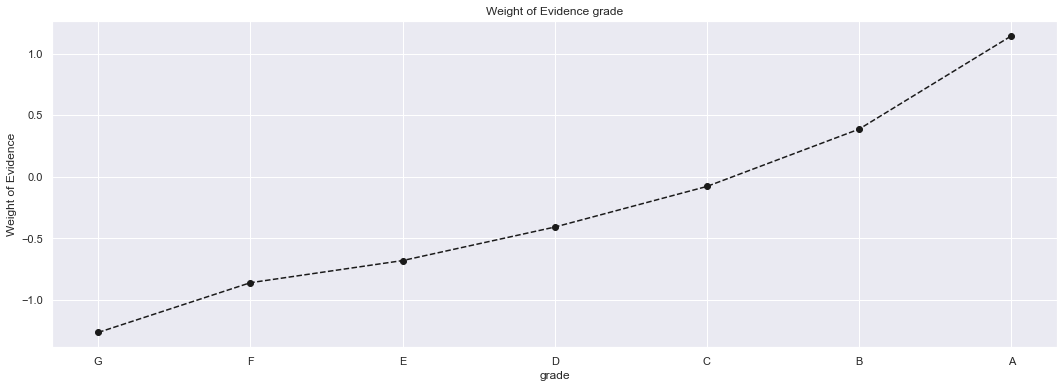

In [259]:
plot_by_woe(df_temp)

## Do rest discrete variables

'home_ownership'

In [260]:
df_temp = woe_discrete(df_inputs_pre, 'home_ownership', df_targets_pre)

In [261]:
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,45,0.777778,0.000483,35.0,10.0,0.000421,0.000981,-0.845478,NaN,NaN,0.022938
1,NONE,10,0.800000,0.000107,8.0,2.0,0.000096,0.000196,-0.711946,0.022222,0.133531,0.022938
2,RENT,37874,0.874003,0.406125,33102.0,4772.0,0.398498,0.468302,-0.161412,0.074003,0.550534,0.022938
3,OWN,8409,0.888572,0.090170,7472.0,937.0,0.089951,0.091953,-0.022006,0.014568,0.139406,0.022938
4,MORTGAGE,46919,0.904751,0.503115,42450.0,4469.0,0.511033,0.438567,0.152922,0.016179,0.174928,0.022938


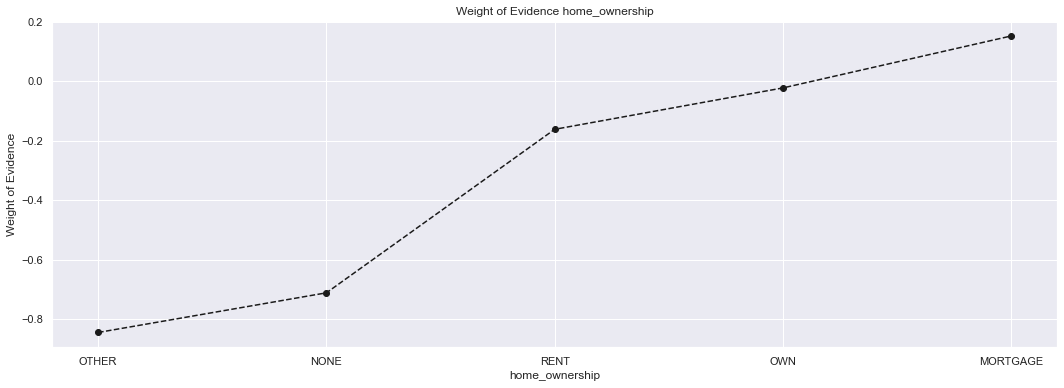

In [262]:
plot_by_woe(df_temp)

Due to high risk and low number of samples, we combine the 'ANY', 'OTHER' and 'NONE' categories to the riskest category with enough number of observations, i.e. 'RENT'

In [263]:
df_inputs_pre['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_pre['home_ownership:RENT'], df_inputs_pre['home_ownership:OTHER'], df_inputs_pre['home_ownership:NONE'], df_inputs_pre['home_ownership:ANY']])

'addr_state'

In [264]:
df_inputs_pre['addr_state'].unique()

array(['CA', 'IN', 'AZ', 'MI', 'PA', 'MO', 'CT', 'IL', 'SC', 'VA', 'NY',
       'FL', 'TX', 'NC', 'NM', 'NJ', 'KY', 'DE', 'OK', 'CO', 'OH', 'GA',
       'LA', 'WA', 'AL', 'TN', 'MD', 'NV', 'MN', 'RI', 'NH', 'MA', 'MS',
       'UT', 'WV', 'HI', 'KS', 'OR', 'WY', 'WI', 'AK', 'DC', 'AR', 'MT',
       'SD', 'VT', 'IA', 'ID', 'ME', 'NE'], dtype=object)

In [265]:
df_temp = woe_discrete(df_inputs_pre, 'addr_state', df_targets_pre)
df_temp

C:\Users\YizhiZhang\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NE,1,0.000000,0.000011,0.0,1.0,0.000000,0.000098,-inf,NaN,NaN,inf
1,ID,2,0.500000,0.000021,1.0,1.0,0.000012,0.000098,-2.098241,0.500000,inf,inf
2,NV,1298,0.855932,0.013919,1111.0,187.0,0.013375,0.018351,-0.316333,0.355932,1.781907,inf
3,HI,486,0.860082,0.005211,418.0,68.0,0.005032,0.006673,-0.282267,0.004150,0.034067,inf
4,FL,6426,0.870059,0.068906,5591.0,835.0,0.067307,0.081943,-0.196759,0.009977,0.085508,inf
5,AL,1182,0.873096,0.012675,1032.0,150.0,0.012424,0.014720,-0.169622,0.003037,0.027137,inf
6,NJ,3676,0.875408,0.039418,3218.0,458.0,0.038740,0.044946,-0.148595,0.002312,0.021027,inf
7,LA,1130,0.876106,0.012117,990.0,140.0,0.011918,0.013739,-0.142178,0.000698,0.006416,inf
8,NY,8031,0.879965,0.086117,7067.0,964.0,0.085076,0.094603,-0.106141,0.003859,0.036038,inf
9,RI,403,0.880893,0.004321,355.0,48.0,0.004274,0.004711,-0.097324,0.000928,0.008817,inf


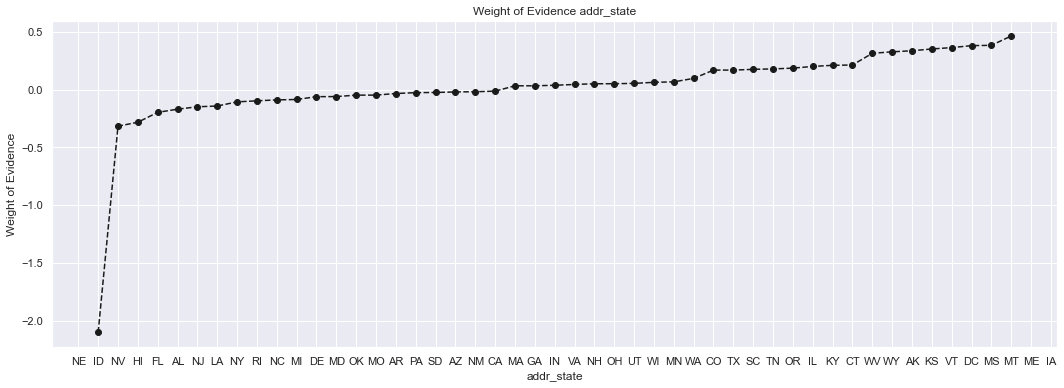

In [266]:
plot_by_woe(df_temp)

In [267]:
if ['addr_state:ND'] in df_inputs_pre.columns.values:
    pass
else:
    df_inputs_pre['addr_state:ND'] = 0

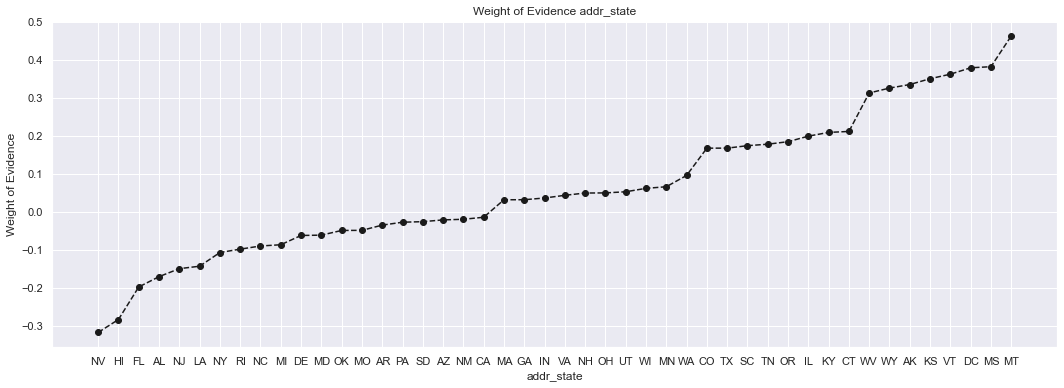

In [268]:
plot_by_woe(df_temp[2:-2])

In [269]:
# combine ND, NE, IA, NV, FL, HI, and AL
df_inputs_pre['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_pre['addr_state:ND'], df_inputs_pre['addr_state:NE'], df_inputs_pre['addr_state:IA'], df_inputs_pre['addr_state:NV'], df_inputs_pre['addr_state:FL'], df_inputs_pre['addr_state:HI'], df_inputs_pre['addr_state:AL']])

In [270]:
# combine WV, NH, WY, DC, ME, ID
df_inputs_pre['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_pre['addr_state:WV'], df_inputs_pre['addr_state:NH'], df_inputs_pre['addr_state:WY'], df_inputs_pre['addr_state:DC'], df_inputs_pre['addr_state:ME'], df_inputs_pre['addr_state:ID']])

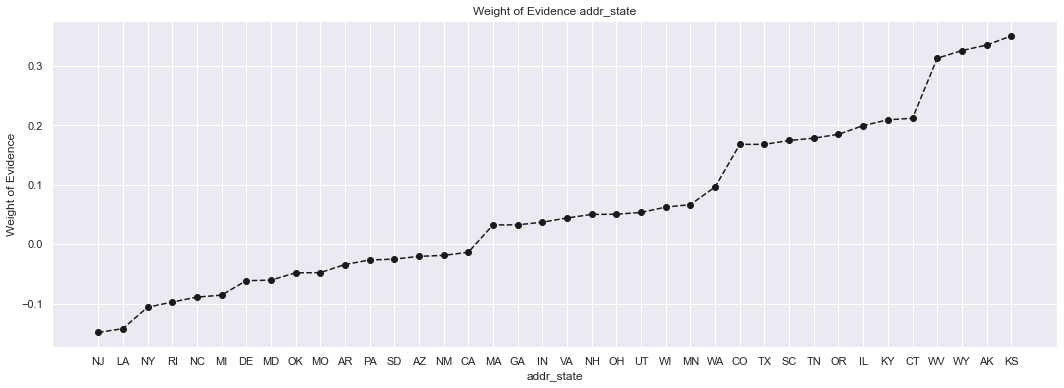

In [271]:
plot_by_woe(df_temp[6:-6])

In [272]:
# combine NM, VA, keep NY
df_inputs_pre['addr_state:NM_VA'] = sum([df_inputs_pre['addr_state:NM'], df_inputs_pre['addr_state:VA']])

In [273]:
# combine OK, TN, MO, LA, MD, NC, keep CA
df_inputs_pre['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_pre['addr_state:OK'], df_inputs_pre['addr_state:TN'], df_inputs_pre['addr_state:MO'], df_inputs_pre['addr_state:LA'], df_inputs_pre['addr_state:MD'], df_inputs_pre['addr_state:NC']])

In [274]:
# combine UT, KY, AZ, NJ
df_inputs_pre['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_pre['addr_state:UT'], df_inputs_pre['addr_state:KY'], df_inputs_pre['addr_state:AZ'], df_inputs_pre['addr_state:NJ']])

In [275]:
# combine AR, MI, PA, OH, MN
df_inputs_pre['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_pre['addr_state:AR'], df_inputs_pre['addr_state:MI'], df_inputs_pre['addr_state:PA'], df_inputs_pre['addr_state:OH'], df_inputs_pre['addr_state:MN']])

In [276]:
# combine RI, MA, DE, SD, IN
df_inputs_pre['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_pre['addr_state:RI'], df_inputs_pre['addr_state:MA'], df_inputs_pre['addr_state:DE'], df_inputs_pre['addr_state:SD'], df_inputs_pre['addr_state:IN']])

In [277]:
# combine GA, WA, OR
df_inputs_pre['addr_state:GA_WA_OR'] = sum([df_inputs_pre['addr_state:GA'], df_inputs_pre['addr_state:WA'], df_inputs_pre['addr_state:OR']])

In [278]:
# combine WI, MT, keep TX
df_inputs_pre['addr_state:WI_MT'] = sum([df_inputs_pre['addr_state:WI'], df_inputs_pre['addr_state:MT']])

In [279]:
# combine IL, CT
df_inputs_pre['addr_state:IL_CT'] = sum([df_inputs_pre['addr_state:IL'], df_inputs_pre['addr_state:CT']])

In [280]:
# combine KS, SC, CO, VT, AK, MS
df_inputs_pre['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_pre['addr_state:KS'], df_inputs_pre['addr_state:CO'], df_inputs_pre['addr_state:SC'], df_inputs_pre['addr_state:VT'], df_inputs_pre['addr_state:AK'], df_inputs_pre['addr_state:MS']])

'verification_status'

In [281]:
df_temp = woe_discrete(df_inputs_pre, 'verification_status', df_targets_pre)
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,33641,0.872031,0.360734,29336.0,4305.0,0.353161,0.422473,-0.179202,NaN,NaN,0.022684
1,Source Verified,29963,0.895738,0.321295,26839.0,3124.0,0.323101,0.306575,0.052501,0.023707,0.231704,0.022684
2,Not Verified,29653,0.906890,0.317971,26892.0,2761.0,0.323739,0.270952,0.177995,0.011152,0.125494,0.022684


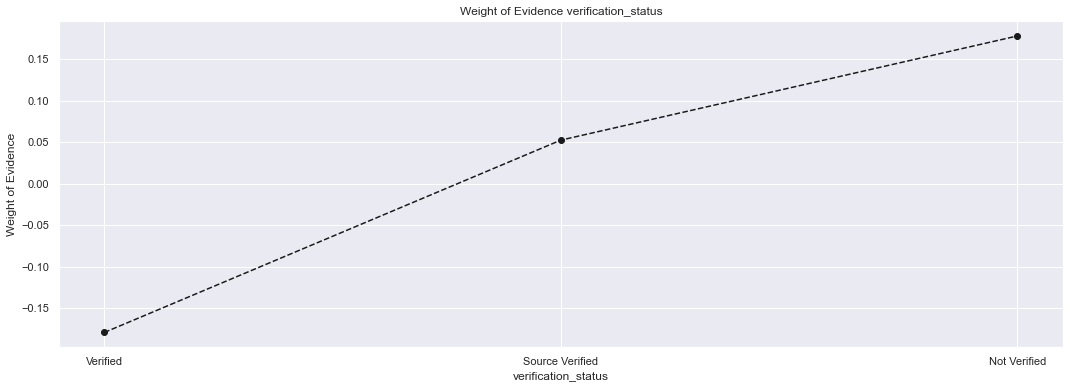

In [282]:
plot_by_woe(df_temp)

In [283]:
# 'verification_status:Not Verified', 'verification_status:Source Verified', verification_status:Verified

'purpose'

In [284]:
df_temp = woe_discrete(df_inputs_pre, 'purpose', df_targets_pre)
df_temp

,purpose,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,educational,89,0.752809,0.000954,67.0,22.0,0.000807,0.002159,-0.984590,NaN,NaN,0.045124
1,renewable_energy,70,0.771429,0.000751,54.0,16.0,0.000650,0.001570,-0.881845,0.018620,0.102745,0.045124
2,small_business,1431,0.777079,0.015345,1112.0,319.0,0.013387,0.031305,-0.849516,0.005650,0.032329,0.045124
3,medical,918,0.857298,0.009844,787.0,131.0,0.009474,0.012856,-0.305210,0.080220,0.544307,0.045124
4,house,439,0.858770,0.004707,377.0,62.0,0.004539,0.006084,-0.293130,0.001471,0.012080,0.045124
5,other,4806,0.861007,0.051535,4138.0,668.0,0.049815,0.065554,-0.274561,0.002237,0.018569,0.045124
6,wedding,456,0.864035,0.004890,394.0,62.0,0.004743,0.006084,-0.249024,0.003028,0.025537,0.045124
7,moving,602,0.878738,0.006455,529.0,73.0,0.006368,0.007164,-0.117712,0.014702,0.131312,0.045124
8,vacation,496,0.881048,0.005319,437.0,59.0,0.005261,0.005790,-0.095845,0.002311,0.021867,0.045124
9,debt_consolidation,55012,0.885916,0.589897,48736.0,6276.0,0.586707,0.615898,-0.048556,0.004867,0.047289,0.045124


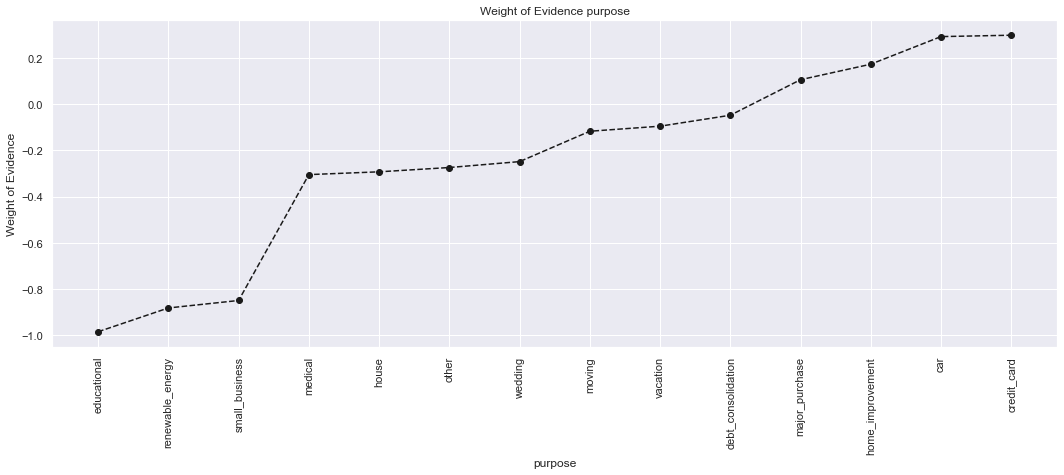

In [285]:
plot_by_woe(df_temp, 90)

In [286]:
# 'purpose:smabus_edu_mov_hou_oth', 'purpose:reen_med_wed_vac', 'purpose:debt_consolidation', 'purpose:hom_maj_car', 'purpose:credit_card'
#df_inputs_pre['purpose:']
df_inputs_pre['purpose:smabus_edu_mov_hou_oth'] = sum([df_inputs_pre['purpose:small_business'], df_inputs_pre['purpose:educational'], df_inputs_pre['purpose:moving'], df_inputs_pre['purpose:house'], df_inputs_pre['purpose:other']])

df_inputs_pre['purpose:reen_med_wed_vac'] = sum([df_inputs_pre['purpose:renewable_energy'], df_inputs_pre['purpose:medical'], df_inputs_pre['purpose:wedding'], df_inputs_pre['purpose:vacation']])

df_inputs_pre['purpose:hom_maj_car'] = sum([df_inputs_pre['purpose:home_improvement'], df_inputs_pre['purpose:major_purchase'], df_inputs_pre['purpose:car']])

'initial_list_status'

In [287]:
df_temp = woe_discrete(df_inputs_pre, 'initial_list_status', df_targets_pre)
df_temp

,initial_list_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,f,60491,0.879685,0.648648,53213.0,7278.0,0.640603,0.71423,-0.108794,NaN,NaN,0.024888
1,w,32766,0.911127,0.351352,29854.0,2912.0,0.359397,0.28577,0.229238,0.031443,0.338032,0.024888


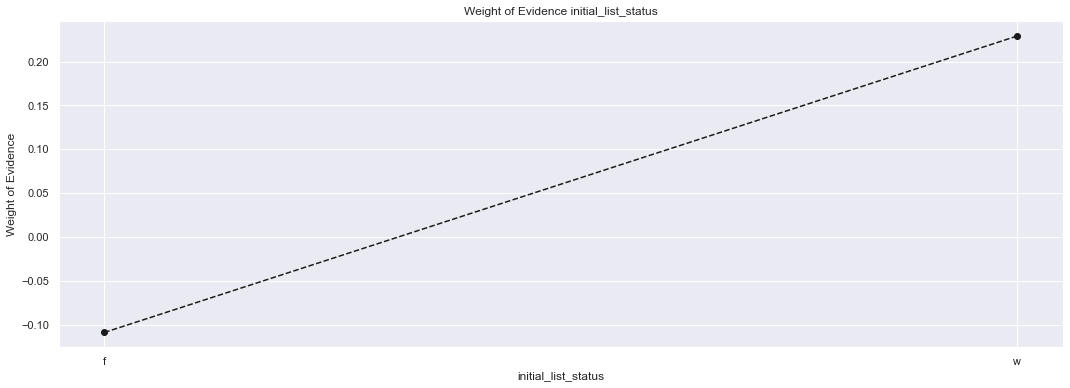

In [288]:
plot_by_woe(df_temp)

In [289]:
#'initial_list_status:f', 'initial_list_status:w'

### Continuous varialbes processing

In [290]:
def woe_ordered_continuous(df, continuous_variable_name, good_bad_variable_df):
    df = pd.concat([df[continuous_variable_name], good_bad_variable_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].count(),
    df.groupby(df.columns.values[0], as_index=False)[df.columns.values[1]].mean()], axis=1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    # df = df.sort_values(['WoE'])
    # df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good']-df['prop_n_bad'])*df['WoE']
    df['IV'] = df['IV'].sum()
    return df

'term_int' variable

In [291]:
df_inputs_pre['term_int'].unique()

array([60, 36], dtype=int64)

In [292]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'term_int', df_targets_pre)

In [293]:
df_temp

,term_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,67534,0.902597,0.724171,60956.0,6578.0,0.733817,0.645535,0.128181,NaN,NaN,0.036603
1,60,25723,0.859581,0.275829,22111.0,3612.0,0.266183,0.354465,-0.286427,0.043016,0.414608,0.036603


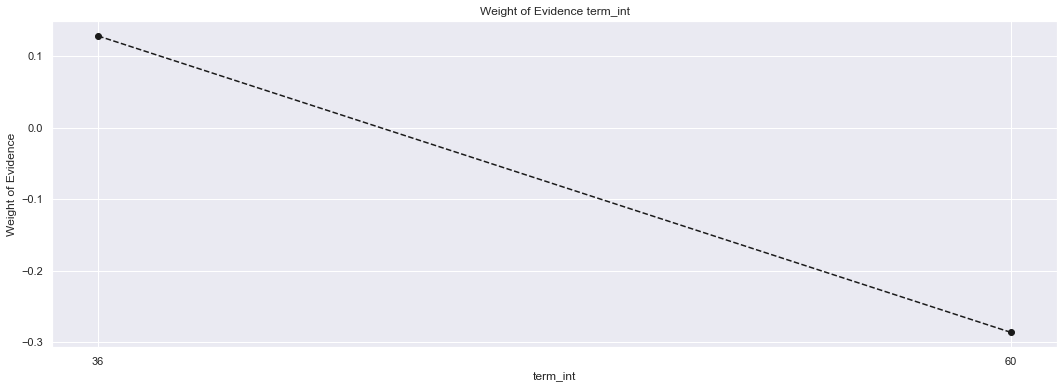

In [294]:
plot_by_woe(df_temp)

In [295]:
# 'term:36', 'term:60'
df_inputs_pre['term:36'] = np.where(df_inputs_pre['term_int'] == 36, 1, 0)
df_inputs_pre['term:60'] = np.where(df_inputs_pre['term_int'] == 60, 1, 0)

'emp_length_int'

In [296]:
df_inputs_pre['emp_length_int'].unique()

array([ 0., 10.,  1.,  2.,  9.,  3.,  6.,  4.,  7.,  8.,  5.])

In [297]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'emp_length_int', df_targets_pre)

In [298]:
df_temp

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,11553,0.874491,0.123883,10103.0,1450.0,0.121625,0.142296,-0.156972,NaN,NaN,0.007766
1,1.0,5968,0.892594,0.063995,5327.0,641.0,0.064129,0.062905,0.019273,0.018102,0.176245,0.007766
2,2.0,8295,0.887402,0.088948,7361.0,934.0,0.088615,0.091658,-0.033766,0.005192,0.053039,0.007766
3,3.0,7391,0.889325,0.079254,6573.0,818.0,0.079129,0.080275,-0.014377,0.001923,0.019389,0.007766
4,4.0,5555,0.889469,0.059567,4941.0,614.0,0.059482,0.060255,-0.012913,0.000144,0.001465,0.007766
5,5.0,6172,0.886261,0.066183,5470.0,702.0,0.065850,0.068891,-0.045140,0.003208,0.032228,0.007766
6,6.0,5225,0.878852,0.056028,4592.0,633.0,0.055281,0.062120,-0.116640,0.007409,0.071500,0.007766
7,7.0,5131,0.893588,0.055020,4585.0,546.0,0.055196,0.053582,0.029686,0.014736,0.146326,0.007766
8,8.0,4542,0.890137,0.048704,4043.0,499.0,0.048672,0.048970,-0.006104,0.003451,0.035790,0.007766
9,9.0,3621,0.892847,0.038828,3233.0,388.0,0.038920,0.038077,0.021920,0.002711,0.028024,0.007766


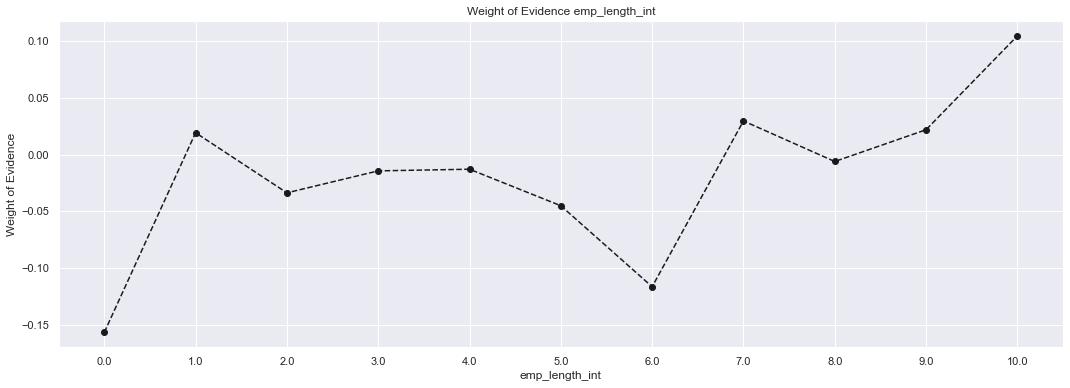

In [299]:
plot_by_woe(df_temp)

In [300]:
# add 'emp_length:0', add 'emp_length:1', add 'emp_length:2-4', add 'emp_length:5-6', add 'emp_length:7-9', add 'emp_length:10'
df_inputs_pre['emp_length:0'] = np.where(df_inputs_pre['emp_length_int'].isin([0]),1,0)
df_inputs_pre['emp_length:1'] = np.where(df_inputs_pre['emp_length_int'].isin([1]),1,0)
df_inputs_pre['emp_length:2-4'] = np.where(df_inputs_pre['emp_length_int'].isin(range(2,5)),1,0)
df_inputs_pre['emp_length:5-6'] = np.where(df_inputs_pre['emp_length_int'].isin(range(5,7)),1,0)
df_inputs_pre['emp_length:7-9'] = np.where(df_inputs_pre['emp_length_int'].isin(range(7,10)),1,0)
df_inputs_pre['emp_length:10'] = np.where(df_inputs_pre['emp_length_int'].isin([10]),1,0)

'mths_since_issue_d'

In [301]:
df_inputs_pre['mths_since_issue_d'].unique()

array([ 41.,  38.,  66.,  37.,  58.,  50.,  86.,  51.,  48.,  59.,  72.,
        77.,  47.,  46.,  56.,  55., 119.,  63., 102.,  39.,  53.,  40.,
        52.,  43.,  49.,  57.,  45.,  36.,  54.,  74.,  44.,  73., 103.,
        70.,  95.,  89.,  68.,  82.,  71.,  76., 104.,  65.,  80.,  91.,
        75.,  67.,  42.,  61.,  64.,  60.,  85.,  88., 110.,  96.,  78.,
        83.,  69.,  90.,  62., 108.,  79.,  92., 118.,  99.,  81., 115.,
        97., 114., 116., 100.,  93., 117., 106., 124., 101., 125.,  87.,
        84.,  94., 105., 109.,  98., 107., 112., 113., 122., 111., 120.,
       121., 123., 126.])

In [302]:
df_inputs_pre['mths_since_issue_d_factor'] = pd.cut(df_inputs_pre['mths_since_issue_d'],50)
df_inputs_pre['mths_since_issue_d_factor']

362514     (39.6, 41.4]
288564     (37.8, 39.6]
213591     (64.8, 66.6]
263083    (35.91, 37.8]
165001     (57.6, 59.4]
              ...      
115        (70.2, 72.0]
296284     (37.8, 39.6]
61777      (48.6, 50.4]
91763      (50.4, 52.2]
167512     (57.6, 59.4]
Name: mths_since_issue_d_factor, Length: 93257, dtype: category
Categories (50, interval[float64]): [(35.91, 37.8] < (37.8, 39.6] < (39.6, 41.4] < (41.4, 43.2] ... (118.8, 120.6] < (120.6, 122.4] < (122.4, 124.2] < (124.2, 126.0]]

In [303]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'mths_since_issue_d_factor', df_targets_pre)
df_temp

,mths_since_issue_d_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(35.91, 37.8]",7191,0.945766,0.077109,6801.0,390.0,0.081874,0.038273,0.760438,NaN,NaN,0.126297
1,"(37.8, 39.6]",9752,0.930373,0.104571,9073.0,679.0,0.109225,0.066634,0.494196,0.015392,0.266241,0.126297
2,"(39.6, 41.4]",9506,0.919945,0.101933,8745.0,761.0,0.105276,0.074681,0.343363,0.010428,0.150833,0.126297
3,"(41.4, 43.2]",7240,0.909116,0.077635,6582.0,658.0,0.079237,0.064573,0.204648,0.010829,0.138715,0.126297
4,"(43.2, 45.0]",7217,0.902868,0.077388,6516.0,701.0,0.078443,0.068793,0.131267,0.006248,0.073381,0.126297
5,"(45.0, 46.8]",3104,0.895296,0.033284,2779.0,325.0,0.033455,0.031894,0.047781,0.007572,0.083487,0.126297
6,"(46.8, 48.6]",6197,0.890269,0.066451,5517.0,680.0,0.066416,0.066732,-0.004744,0.005027,0.052525,0.126297
7,"(48.6, 50.4]",5821,0.885930,0.062419,5157.0,664.0,0.062082,0.065162,-0.048413,0.004339,0.043669,0.126297
8,"(50.4, 52.2]",5021,0.878909,0.053840,4413.0,608.0,0.053126,0.059666,-0.116106,0.007022,0.067693,0.126297
9,"(52.2, 54.0]",4497,0.874138,0.048222,3931.0,566.0,0.047323,0.055545,-0.160186,0.004770,0.044080,0.126297


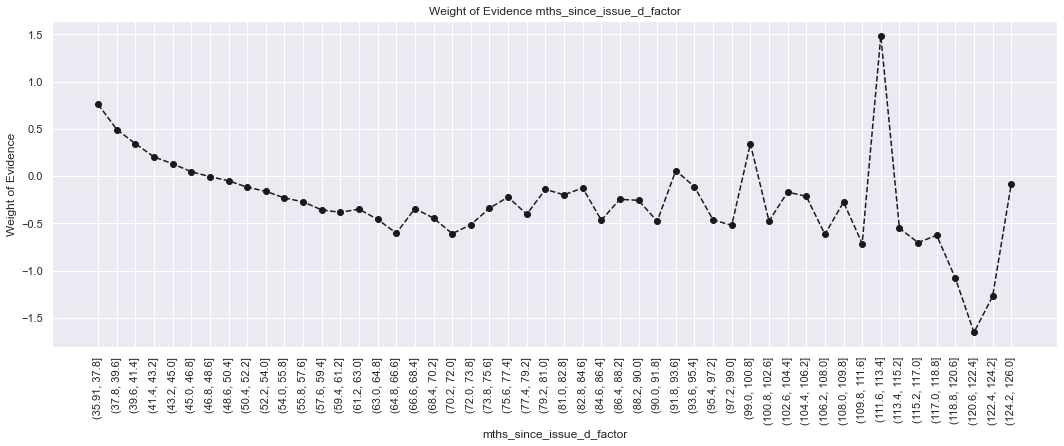

In [304]:
plot_by_woe(df_temp, 90)

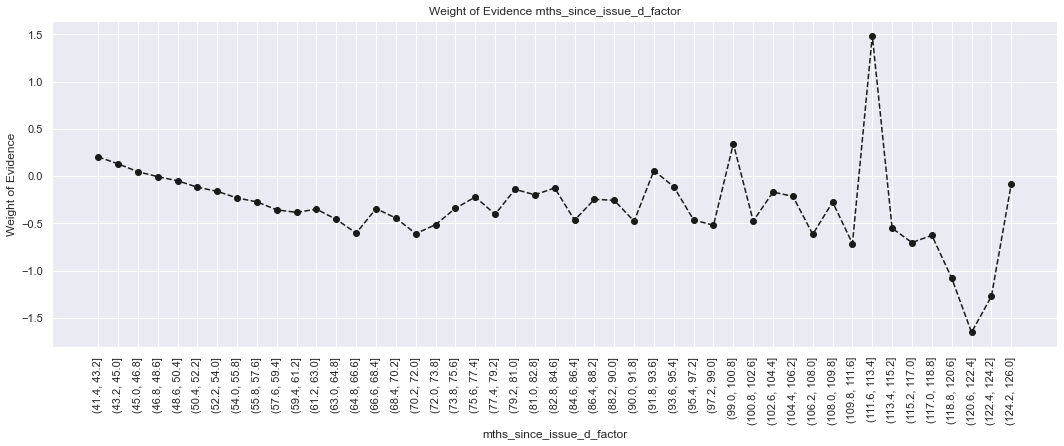

In [305]:
plot_by_woe(df_temp.iloc[3:,:], 90)

In [306]:
# 'mths_since_issue_d::<38', 'mths_since_issue_d:38-39', 'mths_since_issue_d:40-41', 'mths_since_issue_d:42-48', mths_since_issue_d:49-52', 'mths_since_issue_d:53-64', 'mths_since_issue_d:65-84', 'mths_since_issue_d:>84'
df_inputs_pre['mths_since_issue_d::<38'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(38)),1,0)
df_inputs_pre['mths_since_issue_d:38-39'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(38,40)),1,0)  
df_inputs_pre['mths_since_issue_d:40-41'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(40,42)),1,0)  
df_inputs_pre['mths_since_issue_d:42-48'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(42,49)),1,0)
df_inputs_pre['mths_since_issue_d:49-52'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(49,53)),1,0)  
df_inputs_pre['mths_since_issue_d:53-64'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(53,65)),1,0)  
df_inputs_pre['mths_since_issue_d:65-84'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(65,85)),1,0)  
df_inputs_pre['mths_since_issue_d:>84'] = np.where(df_inputs_pre['mths_since_issue_d'].isin(range(85, int(df_inputs_pre['mths_since_issue_d'].max()))),1,0)  

'int_rate'

In [307]:
df_inputs_pre['int_rate_factor'] = pd.cut(df_inputs_pre['int_rate'],50)

In [308]:
df_inputs_pre['int_rate_factor']

362514    (14.914, 15.327]
288564    (20.694, 21.106]
213591    (14.502, 14.914]
263083    (14.089, 14.502]
165001      (8.722, 9.135]
                ...       
115       (11.612, 12.025]
296284     (9.961, 10.374]
61777       (8.722, 9.135]
91763       (8.722, 9.135]
167512      (7.484, 7.897]
Name: int_rate_factor, Length: 93257, dtype: category
Categories (50, interval[float64]): [(5.399, 5.833] < (5.833, 6.246] < (6.246, 6.658] < (6.658, 7.071] ... (24.409, 24.822] < (24.822, 25.234] < (25.234, 25.647] < (25.647, 26.06]]

In [309]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'int_rate_factor', df_targets_pre)

In [310]:
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",198,0.969697,0.002123,192.0,6.0,0.002311,0.000589,1.367495,NaN,NaN,0.371465
1,"(5.833, 6.246]",2086,0.979866,0.022368,2044.0,42.0,0.024607,0.004122,1.786754,0.010169,0.419258,0.371465
2,"(6.246, 6.658]",1974,0.972138,0.021167,1919.0,55.0,0.023102,0.005397,1.453986,0.007728,0.332768,0.371465
3,"(6.658, 7.071]",477,0.951782,0.005115,454.0,23.0,0.005465,0.002257,0.884362,0.020356,0.569623,0.371465
4,"(7.071, 7.484]",804,0.981343,0.008621,789.0,15.0,0.009498,0.001472,1.864475,0.029561,0.980113,0.371465
5,"(7.484, 7.897]",3245,0.965485,0.034796,3133.0,112.0,0.037717,0.010991,1.233007,0.015858,0.631469,0.371465
6,"(7.897, 8.31]",2429,0.951009,0.026046,2310.0,119.0,0.027809,0.011678,0.867639,0.014477,0.365368,0.371465
7,"(8.31, 8.722]",1680,0.965476,0.018015,1622.0,58.0,0.019526,0.005692,1.232732,0.014468,0.365093,0.371465
8,"(8.722, 9.135]",2384,0.942114,0.025564,2246.0,138.0,0.027038,0.013543,0.691412,0.023362,0.541320,0.371465
9,"(9.135, 9.548]",1590,0.976730,0.017050,1553.0,37.0,0.018696,0.003631,1.638785,0.034615,0.947373,0.371465


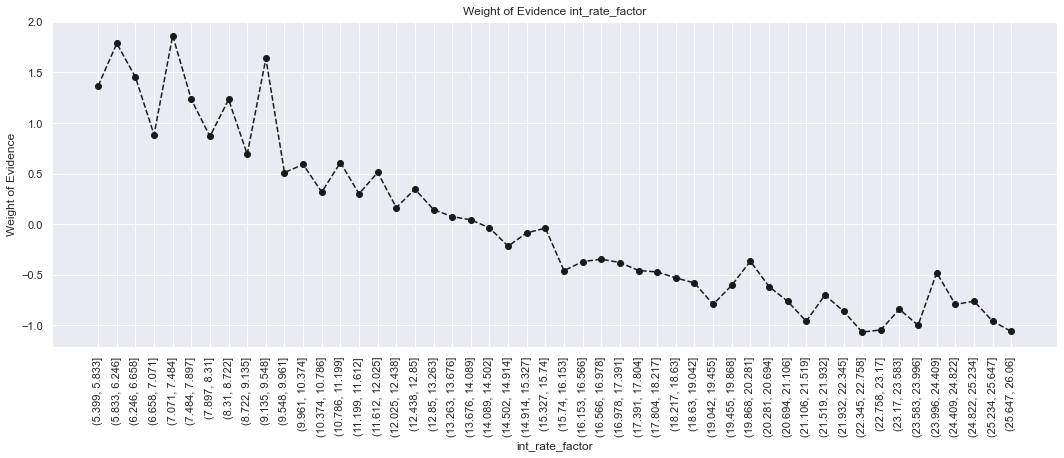

In [311]:
plot_by_woe(df_temp,90)

In [312]:
# 'int_rate:<9.548', 'int_rate:9.548-12.025', 'int_rate:12.025-15.74', 'int_rate:15.75-20.281', 'int_rate:>20.281'
df_inputs_pre['int_rate:<9.548'] = np.where((df_inputs_pre['int_rate']< 9.548),1,0)
df_inputs_pre['int_rate:9.548-12.025'] = np.where((df_inputs_pre['int_rate'] >= 9.548 ) & (df_inputs_pre['int_rate'] < 12.025), 1, 0)
df_inputs_pre['int_rate:12.025-15.74'] = np.where((df_inputs_pre['int_rate'] >= 12.025) & (df_inputs_pre['int_rate'] < 15.74), 1, 0)
df_inputs_pre['int_rate:15.75-20.281'] = np.where((df_inputs_pre['int_rate'] >= 15.74) & (df_inputs_pre['int_rate'] < 20.281), 1, 0)
df_inputs_pre['int_rate:>20.281'] = np.where((df_inputs_pre['int_rate'] >= 20.281), 1, 0)

'funded_amnt'

In [313]:
df_inputs_pre['funded_amnt_factor'] = pd.cut(df_inputs_pre['funded_amnt'], 50)

In [314]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'funded_amnt_factor', df_targets_pre)

In [315]:
df_temp

,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(465.5, 1190.0]",319,0.880878,0.003421,281.0,38.0,0.003383,0.003729,-0.097472,NaN,NaN,0.018663
1,"(1190.0, 1880.0]",800,0.896250,0.008578,717.0,83.0,0.008632,0.008145,0.057995,0.015372,0.155467,0.018663
2,"(1880.0, 2570.0]",1513,0.900198,0.016224,1362.0,151.0,0.016396,0.014818,0.101189,0.003948,0.043194,0.018663
3,"(2570.0, 3260.0]",1817,0.893781,0.019484,1624.0,193.0,0.019550,0.018940,0.031717,0.006417,0.069472,0.018663
4,"(3260.0, 3950.0]",1245,0.891566,0.013350,1110.0,135.0,0.013363,0.013248,0.008600,0.002215,0.023117,0.018663
5,"(3950.0, 4640.0]",2298,0.882942,0.024642,2029.0,269.0,0.024426,0.026398,-0.077654,0.008625,0.086254,0.018663
6,"(4640.0, 5330.0]",3957,0.898155,0.042431,3554.0,403.0,0.042785,0.039549,0.078652,0.015213,0.156305,0.018663
7,"(5330.0, 6020.0]",4186,0.906593,0.044887,3795.0,391.0,0.045686,0.038371,0.174491,0.008438,0.095840,0.018663
8,"(6020.0, 6710.0]",1718,0.881839,0.018422,1515.0,203.0,0.018238,0.019921,-0.088276,0.024754,0.262767,0.018663
9,"(6710.0, 7400.0]",2880,0.893403,0.030882,2573.0,307.0,0.030975,0.030128,0.027739,0.011563,0.116015,0.018663


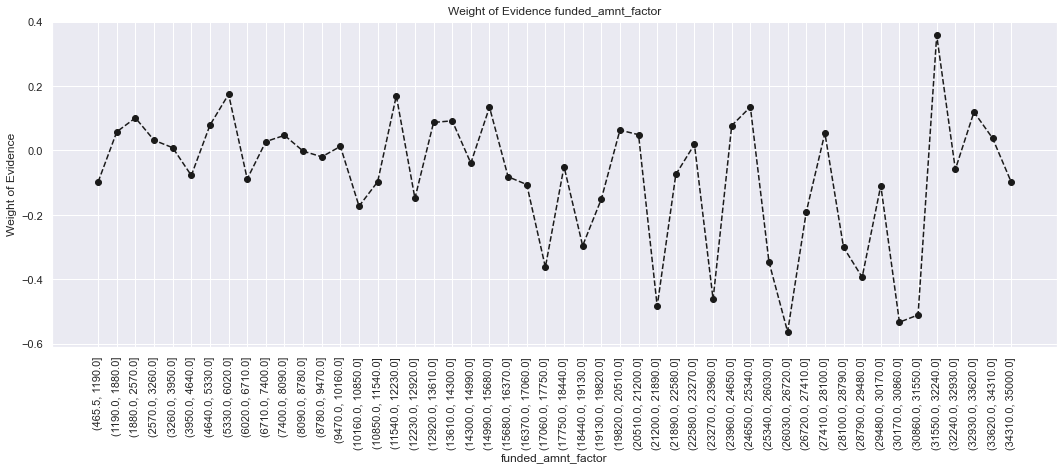

In [316]:
plot_by_woe(df_temp,90)

not to use 'funded_amnt'

'mths_since_earliest_cr_line'

In [317]:
df_inputs_pre['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_pre['mths_since_earliest_cr_line'],50)

In [318]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'mths_since_earliest_cr_line_factor', df_targets_pre)
df_temp

,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.587, 11.74]",5,1.000000,0.000054,5.0,0.0,0.000060,0.000000,inf,NaN,NaN,inf
1,"(11.74, 23.48]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(23.48, 35.22]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(35.22, 46.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(46.96, 58.7]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(58.7, 70.44]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(70.44, 82.18]",182,0.923077,0.001952,168.0,14.0,0.002022,0.001374,0.386666,NaN,NaN,inf
7,"(82.18, 93.92]",508,0.913386,0.005447,464.0,44.0,0.005586,0.004318,0.257454,0.009691,0.129212,inf
8,"(93.92, 105.66]",715,0.851748,0.007667,609.0,106.0,0.007331,0.010402,-0.349861,0.061638,0.607316,inf
9,"(105.66, 117.4]",1268,0.854890,0.013597,1084.0,184.0,0.013050,0.018057,-0.324763,0.003141,0.025098,inf


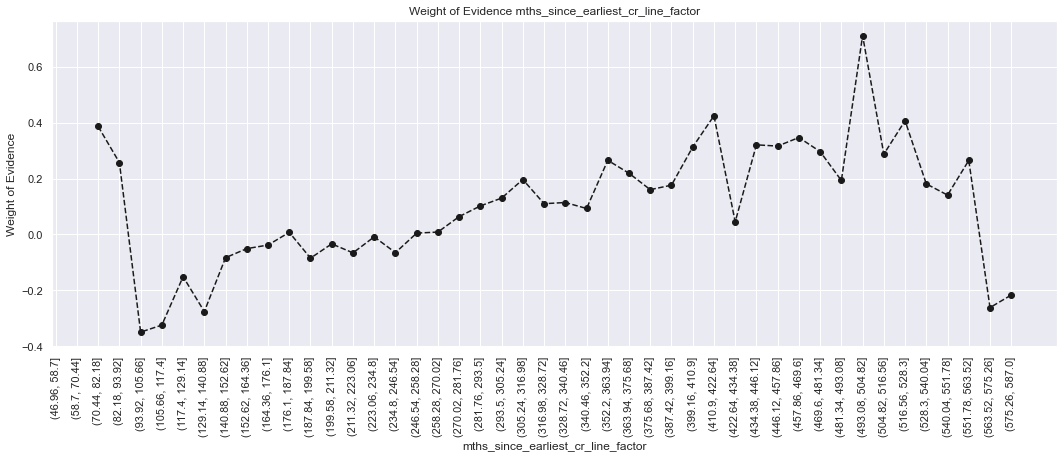

In [319]:
plot_by_woe(df_temp,90)

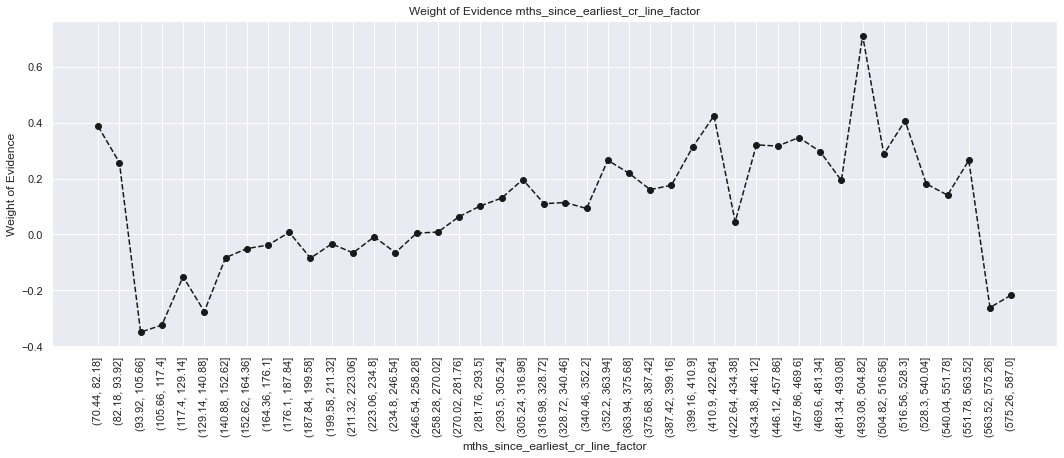

In [320]:
plot_by_woe(df_temp.iloc[6:,:],90)

In [321]:
# 'mths_since_earliest_cr_line:<140', 'mths_since_earliest_cr_line:141-164', 'mths_since_earliest_cr_line:165-247', 'mths_since_earliest_cr_line:248-270', 'mths_since_earliest_cr_line:271-352', 'mths_since_earliest_cr_line:>352'

df_inputs_pre['mths_since_earliest_cr_line:<140'] = np.where(df_inputs_pre['mths_since_earliest_cr_line'].isin(range(140)),1,0)

df_inputs_pre['mths_since_earliest_cr_line:141-164'] = np.where(df_inputs_pre['mths_since_earliest_cr_line'].isin(range(141,165)),1,0)

df_inputs_pre['mths_since_earliest_cr_line:165-247'] = np.where(df_inputs_pre['mths_since_earliest_cr_line'].isin(range(165,248)),1,0)

df_inputs_pre['mths_since_earliest_cr_line:248-270'] = np.where(df_inputs_pre['mths_since_earliest_cr_line'].isin(range(248,271)),1,0)

df_inputs_pre['mths_since_earliest_cr_line:271-352'] = np.where(df_inputs_pre['mths_since_earliest_cr_line'].isin(range(271,353)),1,0)

df_inputs_pre['mths_since_earliest_cr_line:>352'] = np.where(df_inputs_pre['mths_since_earliest_cr_line'].isin(range(353)),1,0)

'delinq_2yrs'

In [322]:
df_inputs_pre['delinq_2yrs'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  6.,  5.,  7., 16.,  8., 18., 10.,  9.,
       13., 11., 14., 12., 19., 15.])

In [323]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'delinq_2yrs', df_targets_pre)
df_temp

,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,76566,0.890944,0.821021,68216.0,8350.0,0.821217,0.819431,0.002177,NaN,NaN,inf
1,1.0,11297,0.890413,0.121138,10059.0,1238.0,0.121095,0.121492,-0.003270,0.000530,0.005447,inf
2,2.0,3192,0.885025,0.034228,2825.0,367.0,0.034009,0.036016,-0.057339,0.005388,0.054069,inf
3,3.0,1134,0.893298,0.012160,1013.0,121.0,0.012195,0.011874,0.026640,0.008273,0.083979,inf
4,4.0,510,0.886275,0.005469,452.0,58.0,0.005441,0.005692,-0.045001,0.007024,0.071642,inf
5,5.0,270,0.911111,0.002895,246.0,24.0,0.002961,0.002355,0.229037,0.024837,0.274039,inf
6,6.0,128,0.859375,0.001373,110.0,18.0,0.001324,0.001766,-0.288132,0.051736,0.517169,inf
7,7.0,67,0.925373,0.000718,62.0,5.0,0.000746,0.000491,0.419456,0.065998,0.707588,inf
8,8.0,29,0.896552,0.000311,26.0,3.0,0.000313,0.000294,0.061244,0.028821,0.358212,inf
9,9.0,22,0.954545,0.000236,21.0,1.0,0.000253,0.000098,0.946282,0.057994,0.885038,inf


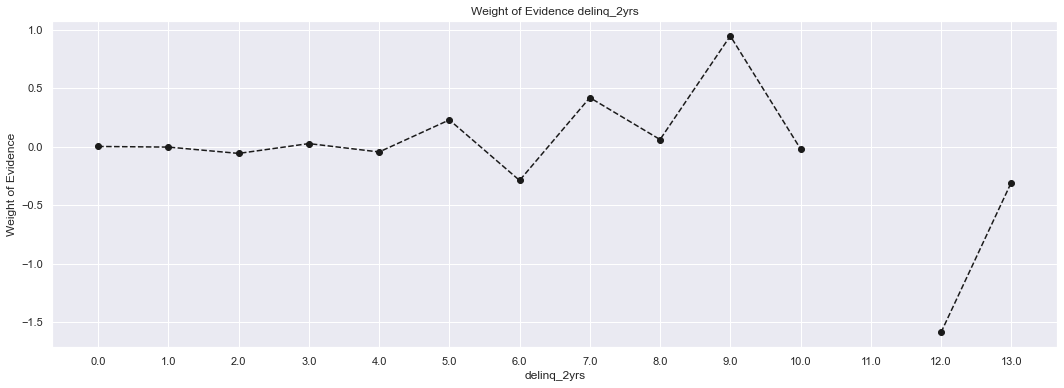

In [324]:
plot_by_woe(df_temp)

In [325]:
# 'delinq_2yrs:0', 'delinq_2yrs:1-3', 'delinq_2yrs:>=4'
df_inputs_pre['delinq_2yrs:0'] = np.where((df_inputs_pre['delinq_2yrs'] == 0), 1, 0)

df_inputs_pre['delinq_2yrs:1-3'] = np.where((df_inputs_pre['delinq_2yrs'] >=1) & (df_inputs_pre['delinq_2yrs'] <=3), 1, 0)

df_inputs_pre['delinq_2yrs:>=4'] = np.where((df_inputs_pre['delinq_2yrs'] >=4), 1, 0)

'inq_last_6mths'

In [326]:
df_inputs_pre['inq_last_6mths'].unique()

array([ 0.,  1.,  2.,  5.,  4.,  6.,  3.,  7.,  8., 11.,  9., 18., 19.,
       24., 10., 12., 13., 14.])

In [327]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'inq_last_6mths', df_targets_pre)
df_temp

C:\Users\YizhiZhang\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,48295,0.910094,0.517870,43953.0,4342.0,0.529127,0.426104,0.216545,NaN,NaN,inf
1,1.0,25985,0.882394,0.278639,22929.0,3056.0,0.276030,0.299902,-0.082945,0.027701,0.299490,inf
2,2.0,11611,0.861252,0.124505,10000.0,1611.0,0.120385,0.158096,-0.272511,0.021141,0.189566,inf
3,3.0,5086,0.846245,0.054537,4304.0,782.0,0.051814,0.076742,-0.392795,0.015008,0.120285,inf
4,4.0,1431,0.841370,0.015345,1204.0,227.0,0.014494,0.022277,-0.429786,0.004875,0.036991,inf
5,5.0,551,0.842105,0.005908,464.0,87.0,0.005586,0.008538,-0.424264,0.000736,0.005522,inf
6,6.0,211,0.763033,0.002263,161.0,50.0,0.001938,0.004907,-0.928859,0.079072,0.504595,inf
7,7.0,36,0.527778,0.000386,19.0,17.0,0.000229,0.001668,-1.987015,0.235255,1.058156,inf
8,8.0,21,0.523810,0.000225,11.0,10.0,0.000132,0.000981,-2.002930,0.003968,0.015915,inf
9,9.0,7,0.428571,0.000075,3.0,4.0,0.000036,0.000393,-2.385923,0.095238,0.382992,inf


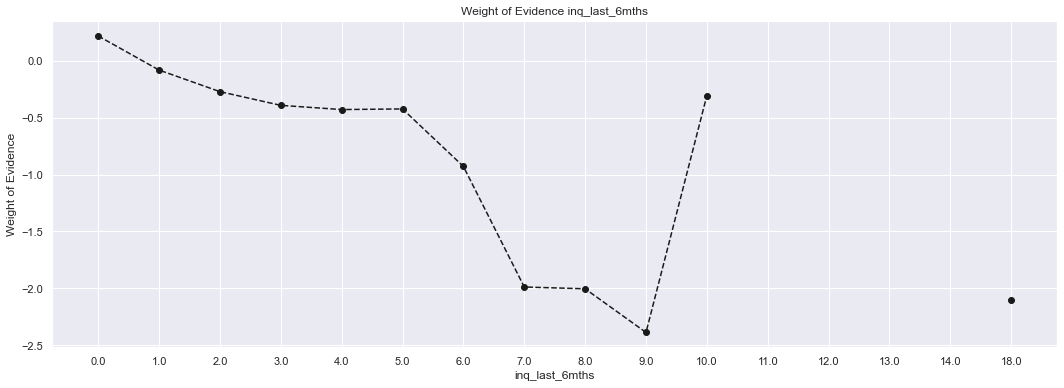

In [328]:
plot_by_woe(df_temp)

In [329]:
# 'inq_last_6mths:0', 'inq_last_6mths:1-2', 'inq_last_6mths:3-6', 'inq_last_6mths:>6'

df_inputs_pre['inq_last_6mths:0'] = np.where((df_inputs_pre['inq_last_6mths'] == 0),  1, 0)
df_inputs_pre['inq_last_6mths:1-2'] = np.where((df_inputs_pre['inq_last_6mths'] >=1) & (df_inputs_pre['inq_last_6mths']<=2),  1, 0)
df_inputs_pre['inq_last_6mths:3-6'] = np.where((df_inputs_pre['inq_last_6mths']>=3) & (df_inputs_pre['inq_last_6mths']<=6),  1, 0)
df_inputs_pre['inq_last_6mths:>6'] = np.where((df_inputs_pre['inq_last_6mths']>6),  1, 0)

'open_acc'

In [330]:
df_inputs_pre['open_acc'].unique()

array([ 7., 18.,  9., 12.,  5., 22.,  3., 17., 16.,  6., 10., 20., 23.,
       13.,  4., 15., 14., 11., 19., 24., 21.,  8., 31., 26.,  1., 32.,
       37., 27., 25.,  2., 28., 29., 30., 39., 34., 33., 35., 36., 40.,
        0., 38., 53., 48., 52., 46., 42., 45., 43., 58., 41., 49., 61.,
       50.])

In [331]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'open_acc', df_targets_pre)
df_temp

,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,7,1.000000,0.000075,7.0,0.0,0.000084,0.000000,inf,NaN,NaN,inf
1,1.0,32,0.875000,0.000343,28.0,4.0,0.000337,0.000393,-0.152331,0.125000,inf,inf
2,2.0,334,0.838323,0.003582,280.0,54.0,0.003371,0.005299,-0.452435,0.036677,0.300105,inf
3,3.0,1122,0.852941,0.012031,957.0,165.0,0.011521,0.016192,-0.340383,0.014618,0.112052,inf
4,4.0,2560,0.892188,0.027451,2284.0,276.0,0.027496,0.027085,0.015042,0.039246,0.355425,inf
5,5.0,4403,0.891438,0.047214,3925.0,478.0,0.047251,0.046909,0.007270,0.000750,0.007772,inf
6,6.0,6216,0.890766,0.066655,5537.0,679.0,0.066657,0.066634,0.000346,0.000672,0.006924,inf
7,7.0,7433,0.886856,0.079704,6592.0,841.0,0.079358,0.082532,-0.039220,0.003910,0.039567,inf
8,8.0,8314,0.893433,0.089151,7428.0,886.0,0.089422,0.086948,0.028054,0.006577,0.067275,inf
9,9.0,8768,0.888230,0.094020,7788.0,980.0,0.093756,0.096173,-0.025454,0.005203,0.053508,inf


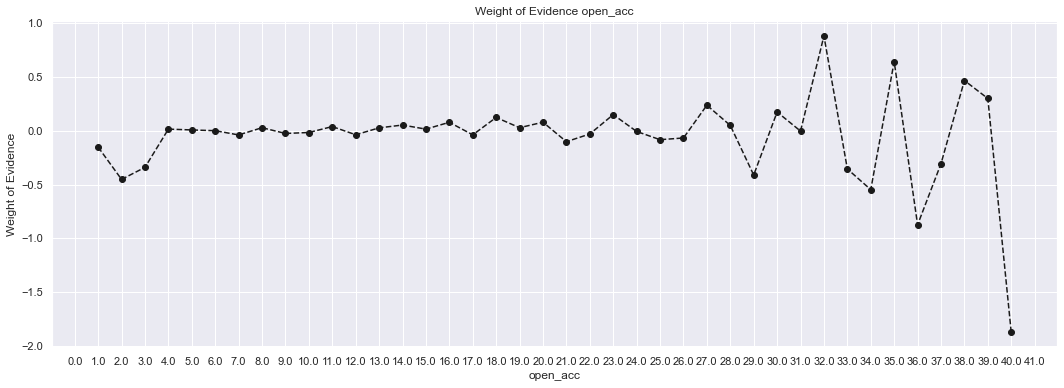

In [332]:
plot_by_woe(df_temp)

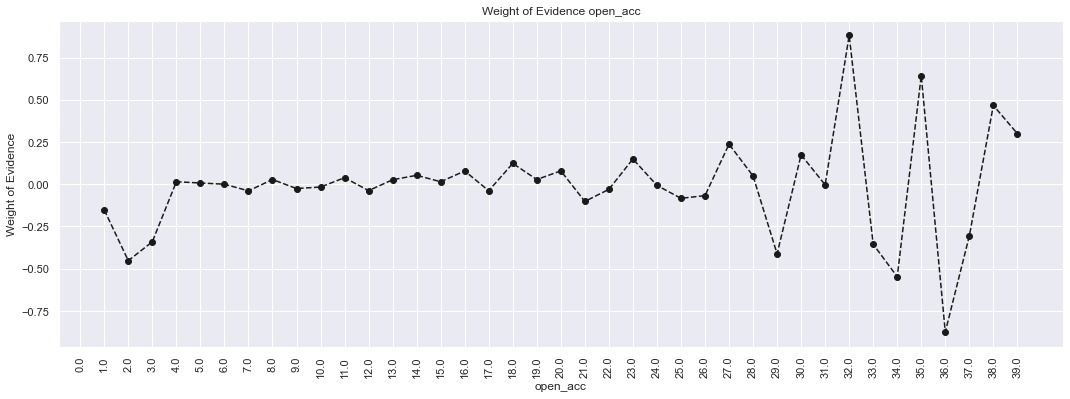

In [333]:
plot_by_woe(df_temp.iloc[:40,:],90)

In [334]:
# 'open_acc:0', 'open_acc:1-3', 'open_acc:4-12', 'open_acc:13-22', 'open_acc:23-25', 'open_acc:26-30' 'open_acc:>30'

df_inputs_pre['open_acc:0'] = np.where((df_inputs_pre['open_acc'] ==0), 1, 0)

df_inputs_pre['open_acc:1-3'] = np.where((df_inputs_pre['open_acc'] >= 1) & (df_inputs_pre['open_acc'] <= 3), 1, 0)

df_inputs_pre['open_acc:4-12'] = np.where((df_inputs_pre['open_acc'] >= 4) & (df_inputs_pre['open_acc'] <= 12), 1, 0)

df_inputs_pre['open_acc:13-22'] = np.where((df_inputs_pre['open_acc'] >= 13) & (df_inputs_pre['open_acc'] <= 22), 1, 0)

df_inputs_pre['open_acc:23-25'] = np.where((df_inputs_pre['open_acc'] >= 23) & (df_inputs_pre['open_acc'] <= 25), 1, 0)

df_inputs_pre['open_acc:26-30'] = np.where((df_inputs_pre['open_acc'] >= 26) & (df_inputs_pre['open_acc'] <= 30), 1, 0)

df_inputs_pre['open_acc:>30'] = np.where((df_inputs_pre['open_acc'] >= 31), 1, 0)

'pub_rec'

In [335]:
df_inputs_pre['pub_rec'].unique()

array([ 0.,  1.,  2.,  4.,  3.,  5., 12., 49.,  7.,  6.,  8., 14., 11.,
       10.,  9.])

In [336]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'pub_rec', df_targets_pre)
df_temp

,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,80923,0.889179,0.867742,71955.0,8968.0,0.866228,0.880079,-0.015862,NaN,NaN,inf
1,1.0,10670,0.901125,0.114415,9615.0,1055.0,0.115750,0.103533,0.111543,0.011946,0.127405,inf
2,2.0,1097,0.904284,0.011763,992.0,105.0,0.011942,0.010304,0.147522,0.003160,0.035979,inf
3,3.0,331,0.900302,0.003549,298.0,33.0,0.003587,0.003238,0.102345,0.003982,0.045177,inf
4,4.0,112,0.857143,0.001201,96.0,16.0,0.001156,0.001570,-0.306481,0.043159,0.408826,inf
5,5.0,73,0.904110,0.000783,66.0,7.0,0.000795,0.000687,0.145504,0.046967,0.451985,inf
6,6.0,19,0.894737,0.000204,17.0,2.0,0.000205,0.000196,0.041825,0.009373,0.103678,inf
7,7.0,14,0.785714,0.000150,11.0,3.0,0.000132,0.000294,-0.798958,0.109023,0.840783,inf
8,8.0,5,0.800000,0.000054,4.0,1.0,0.000048,0.000098,-0.711946,0.014286,0.087011,inf
9,9.0,2,1.000000,0.000021,2.0,0.0,0.000024,0.000000,inf,0.200000,inf,inf


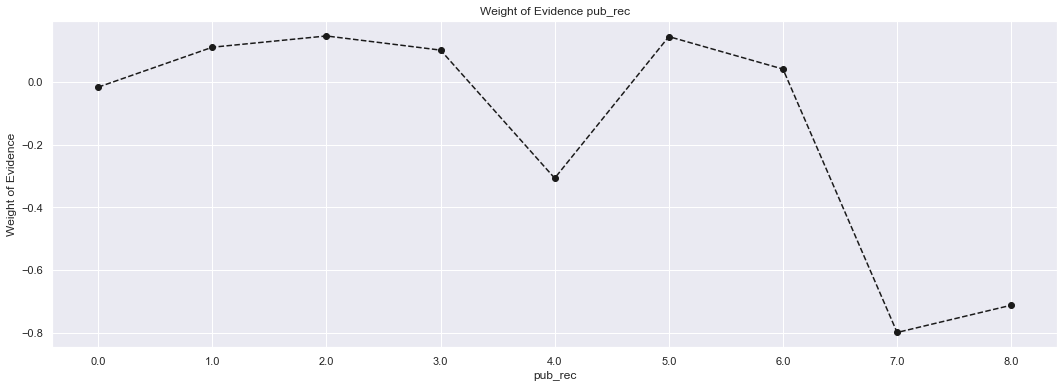

In [337]:
plot_by_woe(df_temp)

In [338]:
# 'pub_rec:0',  'pub_rec:1-2',  'pub_rec:3-6', 'pub_rec:>6'

df_inputs_pre['pub_rec:0'] = np.where((df_inputs_pre['pub_rec'] == 0), 1, 0)

df_inputs_pre['pub_rec:1-2'] = np.where((df_inputs_pre['pub_rec'] >= 1) & (df_inputs_pre['pub_rec'] <= 2), 1, 0)

df_inputs_pre['pub_rec:3-6'] = np.where((df_inputs_pre['pub_rec'] >= 3) & (df_inputs_pre['pub_rec'] <= 6), 1, 0)

df_inputs_pre['pub_rec:>6'] = np.where((df_inputs_pre['pub_rec'] > 6), 1, 0)

'total_acc'

In [339]:
df_inputs_pre['total_acc'].describe()
df_inputs_pre['total_acc'].unique()

array([ 20.,  43.,  38.,  31.,  36.,  48.,  10.,  45.,   5.,  32.,  26.,
        41.,  40.,  47.,   8.,  14.,  42.,  24.,   6.,  23.,  17.,  11.,
        25.,  21.,  28.,  29.,  12.,  37.,  19.,  35.,  34.,  30.,  18.,
        13.,   9.,  44.,  50.,  22.,  33.,  59.,  16.,  15.,  27.,  39.,
        46.,  63.,   7.,  52.,  56.,  54.,  49.,   4.,  57.,  60.,  53.,
        67.,  51.,  55.,  65.,  61., 156.,   3.,  66.,  58.,  80.,  64.,
        62.,  73.,  71.,  72.,  91.,  79.,  69.,   2.,  78.,   0.,  81.,
        92.,  74.,  70.,  77.,  75.,  68.,  76.,  85.,  88.,  94.,  97.,
         1.,  99.,  86.,  89.,  84.,  83.,  82.,  93.])

In [340]:
df_inputs_pre['total_acc_factor'] = pd.cut(df_inputs_pre['total_acc'], 50)
df_temp = woe_ordered_continuous(df_inputs_pre, 'total_acc_factor', df_targets_pre)
df_temp

,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.156, 3.12]",125,0.776000,0.001340,97.0,28.0,0.001168,0.002748,-0.855734,NaN,NaN,inf
1,"(3.12, 6.24]",1499,0.850567,0.016074,1275.0,224.0,0.015349,0.021982,-0.359185,0.074567,0.496549,inf
2,"(6.24, 9.36]",3715,0.871871,0.039836,3239.0,476.0,0.038993,0.046712,-0.180639,0.021304,0.178547,inf
3,"(9.36, 12.48]",6288,0.874841,0.067427,5501.0,787.0,0.066224,0.077233,-0.153784,0.002970,0.026855,inf
4,"(12.48, 15.6]",8289,0.888286,0.088883,7363.0,926.0,0.088639,0.090873,-0.024892,0.013445,0.128892,inf
5,"(15.6, 18.72]",9843,0.890176,0.105547,8762.0,1081.0,0.105481,0.106084,-0.005703,0.001890,0.019189,inf
6,"(18.72, 21.84]",10270,0.893866,0.110126,9180.0,1090.0,0.110513,0.106968,0.032609,0.003690,0.038312,inf
7,"(21.84, 24.96]",9971,0.892789,0.106920,8902.0,1069.0,0.107167,0.104907,0.021312,0.001077,0.011297,inf
8,"(24.96, 28.08]",11873,0.892108,0.127315,10592.0,1281.0,0.127512,0.125711,0.014217,0.000681,0.007094,inf
9,"(28.08, 31.2]",7289,0.892715,0.078160,6507.0,782.0,0.078334,0.076742,0.020538,0.000607,0.006321,inf


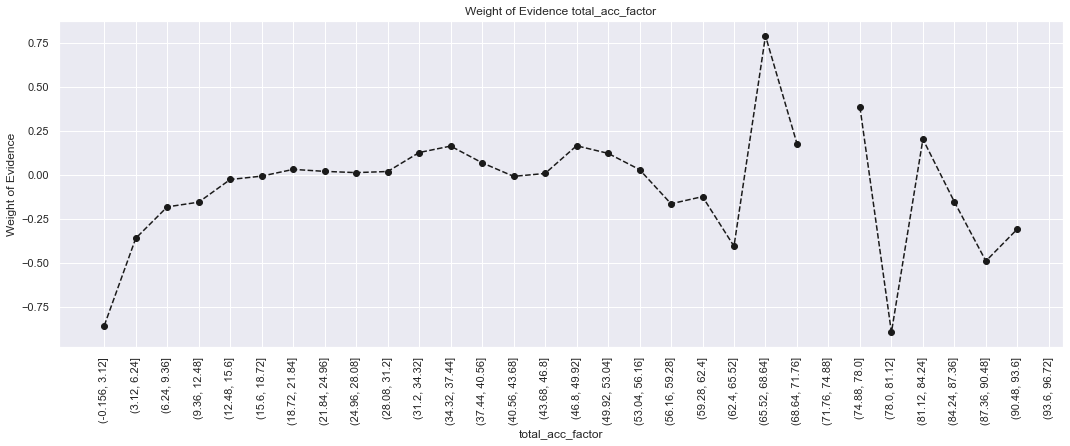

In [341]:
plot_by_woe(df_temp,90)

In [342]:
# 'total_acc:<=9', 'total_acc:10-21', 'total_acc:22-33', 'total_acc:34-51', 'total_acc:>51'

df_inputs_pre['total_acc:<=9'] = np.where((df_inputs_pre['total_acc'] <= 9), 1, 0)

df_inputs_pre['total_acc:10-21'] = np.where((df_inputs_pre['total_acc'] >= 10) & (df_inputs_pre['total_acc'] <= 21), 1, 0)

df_inputs_pre['total_acc:22-33'] = np.where((df_inputs_pre['total_acc'] >= 22) & (df_inputs_pre['total_acc'] <= 33), 1, 0)

df_inputs_pre['total_acc:34-51'] = np.where((df_inputs_pre['total_acc'] >= 34) & (df_inputs_pre['total_acc'] <= 51), 1, 0)

df_inputs_pre['total_acc:>51'] = np.where((df_inputs_pre['total_acc'] > 51), 1, 0)

'acc_now_delinq'

In [343]:
df_inputs_pre['acc_now_delinq'].unique()

array([0., 1., 2., 3.])

In [344]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'acc_now_delinq', df_targets_pre)
df_temp

,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,92871,0.890827,0.995861,82732.0,10139.0,0.995967,0.994995,0.000976,NaN,NaN,0.000298
1,1.0,360,0.872222,0.003860,314.0,46.0,0.003780,0.004514,-0.177489,0.018605,0.178466,0.000298
2,2.0,22,0.818182,0.000236,18.0,4.0,0.000217,0.000393,-0.594163,0.054040,0.416674,0.000298
3,3.0,4,0.750000,0.000043,3.0,1.0,0.000036,0.000098,-0.999628,0.068182,0.405465,0.000298


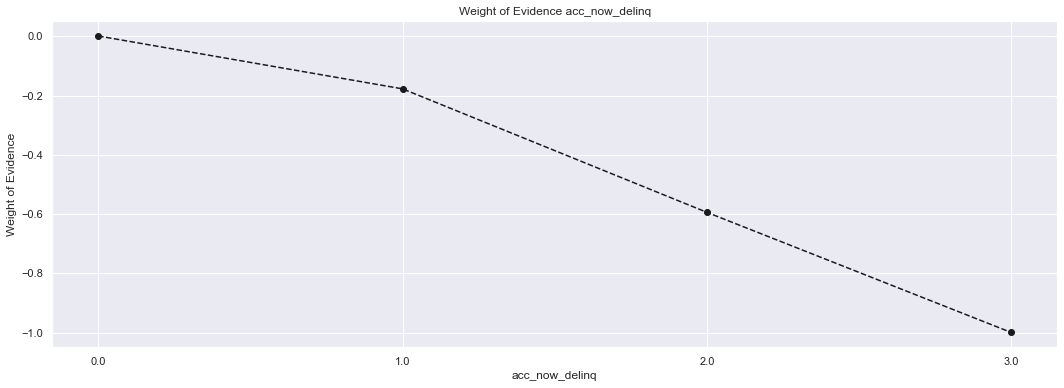

In [345]:
plot_by_woe(df_temp)

In [346]:
# 'acc_now_delinq:0','acc_now_delinq:>=1'

df_inputs_pre['acc_now_delinq:0'] = np.where((df_inputs_pre['acc_now_delinq'] == 0), 1, 0)

df_inputs_pre['acc_now_delinq:>=1'] = np.where((df_inputs_pre['acc_now_delinq'] >= 1), 1, 0)

'total_rev_hi_lim'

In [347]:
df_inputs_pre['total_rev_hi_lim'].nunique()

4926

In [348]:
df_inputs_pre['total_rev_hi_lim'].describe()

count    9.325700e+04
mean     2.758552e+04
std      2.939144e+04
min      0.000000e+00
25%      1.150000e+04
50%      2.010000e+04
75%      3.450000e+04
max      2.013133e+06
Name: total_rev_hi_lim, dtype: float64

In [349]:
df_inputs_pre_temp = df_inputs_pre[df_inputs_pre['total_rev_hi_lim'] < 200000]

In [350]:
df_inputs_pre_temp['total_rev_hi_lim_factor'] = pd.cut(df_inputs_pre_temp['total_rev_hi_lim'], 50)

C:\Users\YizhiZhang\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [351]:
df_temp = woe_ordered_continuous(df_inputs_pre_temp, 'total_rev_hi_lim_factor', df_targets_pre[df_inputs_pre_temp.index])
df_temp

,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-199.6, 3992.0]",3023,0.854118,0.032521,2582.0,441.0,0.031190,0.043350,-0.329199,NaN,NaN,inf
1,"(3992.0, 7984.0]",9482,0.872706,0.102006,8275.0,1207.0,0.099961,0.118647,-0.171373,0.018588,0.157826,inf
2,"(7984.0, 11976.0]",11751,0.875330,0.126416,10286.0,1465.0,0.124254,0.144009,-0.147545,0.002624,0.023828,inf
3,"(11976.0, 15968.0]",11767,0.880513,0.126588,10361.0,1406.0,0.125160,0.138209,-0.099174,0.005184,0.048371,inf
4,"(15968.0, 19960.0]",9745,0.881375,0.104836,8589.0,1156.0,0.103754,0.113634,-0.090957,0.000862,0.008217,inf
5,"(19960.0, 23952.0]",8522,0.889345,0.091679,7579.0,943.0,0.091554,0.092696,-0.012403,0.007970,0.078554,inf
6,"(23952.0, 27944.0]",7045,0.890703,0.075789,6275.0,770.0,0.075802,0.075691,0.001465,0.001357,0.013868,inf
7,"(27944.0, 31936.0]",5597,0.901912,0.060212,5048.0,549.0,0.060979,0.053966,0.122175,0.011209,0.120711,inf
8,"(31936.0, 35928.0]",4695,0.892439,0.050508,4190.0,505.0,0.050615,0.049641,0.019424,0.009473,0.102751,inf
9,"(35928.0, 39920.0]",3622,0.895362,0.038965,3243.0,379.0,0.039175,0.037255,0.050244,0.002923,0.030820,inf


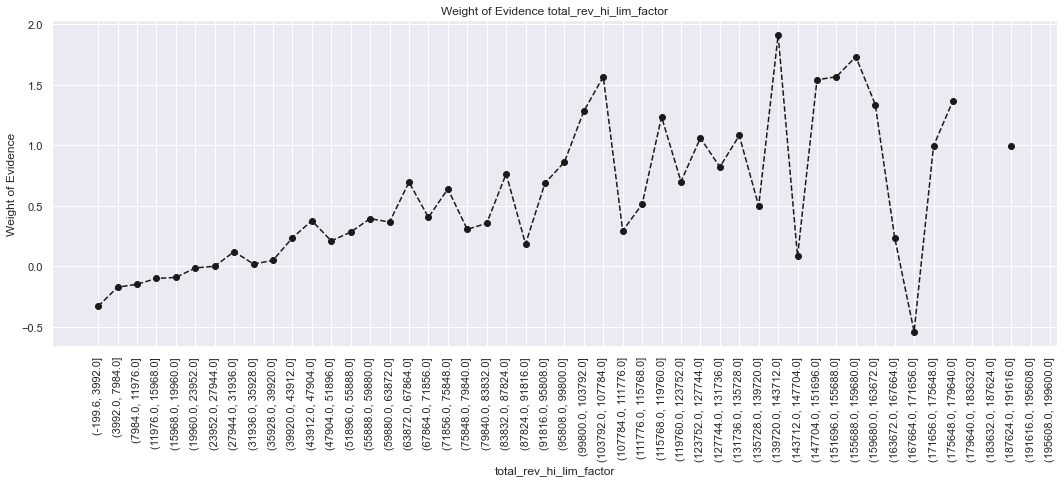

In [352]:
plot_by_woe(df_temp,90)

In [353]:
# 'total_rev_hi_lim:<36K', 'total_rev_hi_lim:36K-56K', 'total_rev_hi_lim:56K-92K', 'total_rev_hi_lim:>92K'

df_inputs_pre['total_rev_hi_lim:<36K'] = np.where((df_inputs_pre['total_rev_hi_lim'] < 36000), 1, 0)

df_inputs_pre['total_rev_hi_lim:36K-56K'] = np.where((df_inputs_pre['total_rev_hi_lim'] >= 36000) & (df_inputs_pre['total_rev_hi_lim'] < 56000), 1, 0)

df_inputs_pre['total_rev_hi_lim:56K-92K'] = np.where((df_inputs_pre['total_rev_hi_lim'] >= 56000) & (df_inputs_pre['total_rev_hi_lim'] < 92000), 1, 0)

df_inputs_pre['total_rev_hi_lim:>92K'] = np.where((df_inputs_pre['total_rev_hi_lim'] <= 92000), 1, 0)

'installment'

In [354]:
df_inputs_pre['installment'].nunique()

26917

In [355]:
df_inputs_pre['installment_factor'] = pd.cut(df_inputs_pre['installment'],50)

In [356]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'installment_factor', df_targets_pre)
df_temp

,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(14.369, 43.585]",485,0.872165,0.005201,423.0,62.0,0.005092,0.006084,-0.178003,NaN,NaN,inf
1,"(43.585, 71.41]",1246,0.904494,0.013361,1127.0,119.0,0.013567,0.011678,0.149950,0.032329,0.327953,inf
2,"(71.41, 99.235]",1731,0.895436,0.018562,1550.0,181.0,0.018660,0.017763,0.049273,0.009058,0.100678,inf
3,"(99.235, 127.06]",2292,0.896597,0.024577,2055.0,237.0,0.024739,0.023258,0.061730,0.001161,0.012458,inf
4,"(127.06, 154.885]",2602,0.886241,0.027901,2306.0,296.0,0.027761,0.029048,-0.045330,0.010356,0.107061,inf
5,"(154.885, 182.71]",4133,0.897653,0.044318,3710.0,423.0,0.044663,0.041511,0.073174,0.011412,0.118505,inf
6,"(182.71, 210.535]",4109,0.905086,0.044061,3719.0,390.0,0.044771,0.038273,0.156823,0.007433,0.083648,inf
7,"(210.535, 238.36]",3730,0.901877,0.039997,3364.0,366.0,0.040497,0.035918,0.120012,0.003210,0.036811,inf
8,"(238.36, 266.185]",4660,0.899785,0.049969,4193.0,467.0,0.050477,0.045829,0.096602,0.002091,0.023410,inf
9,"(266.185, 294.01]",4975,0.888844,0.053347,4422.0,553.0,0.053234,0.054269,-0.019251,0.010941,0.115853,inf


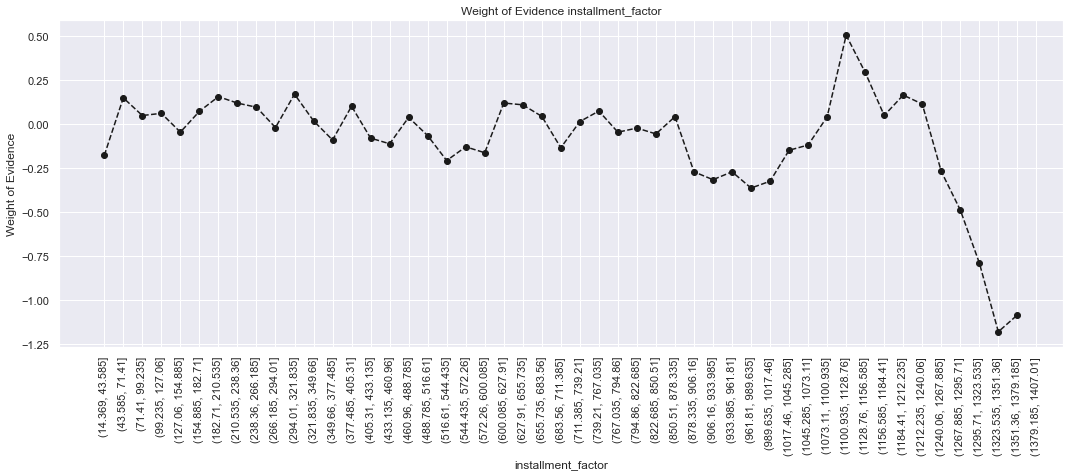

In [357]:
plot_by_woe(df_temp,90)

In [358]:
# do not use 'installment'

'annual_inc'

In [359]:
df_inputs_pre['annual_inc_factor'] = pd.cut(df_inputs_pre['annual_inc'],50)

In [360]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'annual_inc_factor', df_targets_pre)

In [361]:
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-2695.2, 154704.0]",89203,0.889040,0.956529,79305.0,9898.0,0.954711,0.971344,-0.017272,NaN,NaN,inf
1,"(154704.0, 304608.0]",3626,0.926641,0.038882,3360.0,266.0,0.040449,0.026104,0.437959,0.037601,0.455231,inf
2,"(304608.0, 454512.0]",282,0.929078,0.003024,262.0,20.0,0.003154,0.001963,0.474372,0.002437,0.036412,inf
3,"(454512.0, 604416.0]",86,0.965116,0.000922,83.0,3.0,0.000999,0.000294,1.221988,0.036038,0.747616,inf
4,"(604416.0, 754320.0]",23,0.956522,0.000247,22.0,1.0,0.000265,0.000098,0.992802,0.008595,0.229186,inf
5,"(754320.0, 904224.0]",18,0.944444,0.000193,17.0,1.0,0.000205,0.000098,0.734973,0.012077,0.257829,inf
6,"(904224.0, 1054128.0]",7,1.000000,0.000075,7.0,0.0,0.000084,0.000000,inf,0.055556,inf,inf
7,"(1054128.0, 1204032.0]",6,1.000000,0.000064,6.0,0.0,0.000072,0.000000,inf,0.000000,NaN,inf
8,"(1204032.0, 1353936.0]",2,0.500000,0.000021,1.0,1.0,0.000012,0.000098,-2.098241,0.500000,inf,inf
9,"(1353936.0, 1503840.0]",2,1.000000,0.000021,2.0,0.0,0.000024,0.000000,inf,0.500000,inf,inf


In [362]:
# one dummy for high income 'annual_inc:>140000'

In [363]:
df_inputs_pre_temp = df_inputs_pre[df_inputs_pre['annual_inc']<=140000]

In [364]:
df_inputs_pre_temp['annual_inc_factor'] = pd.cut(df_inputs_pre_temp['annual_inc'],50)

C:\Users\YizhiZhang\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [365]:
df_temp = woe_ordered_continuous(df_inputs_pre_temp, 'annual_inc_factor', df_targets_pre[df_inputs_pre['annual_inc']<=140000])

In [366]:
df_temp

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(4664.8, 7504.0]",10,1.000000,0.000114,10.0,0.0,0.000128,0.000000,inf,NaN,NaN,inf
1,"(7504.0, 10208.0]",84,0.761905,0.000958,64.0,20.0,0.000822,0.002043,-0.911157,0.238095,inf,inf
2,"(10208.0, 12912.0]",123,0.780488,0.001403,96.0,27.0,0.001232,0.002758,-0.805796,0.018583,0.105361,inf
3,"(12912.0, 15616.0]",304,0.851974,0.003467,259.0,45.0,0.003325,0.004597,-0.324142,0.071486,0.481654,inf
4,"(15616.0, 18320.0]",383,0.827676,0.004368,317.0,66.0,0.004069,0.006743,-0.505060,0.024297,0.180919,inf
5,"(18320.0, 21024.0]",733,0.840382,0.008359,616.0,117.0,0.007907,0.011953,-0.413234,0.012706,0.091826,inf
6,"(21024.0, 23728.0]",704,0.846591,0.008028,596.0,108.0,0.007651,0.011034,-0.366198,0.006209,0.047036,inf
7,"(23728.0, 26432.0]",1785,0.861064,0.020356,1537.0,248.0,0.019730,0.025337,-0.250148,0.014474,0.116050,inf
8,"(26432.0, 29136.0]",1355,0.853137,0.015452,1156.0,199.0,0.014839,0.020331,-0.314891,0.007928,0.064743,inf
9,"(29136.0, 31840.0]",2292,0.854276,0.026137,1958.0,334.0,0.025134,0.034123,-0.305769,0.001139,0.009122,inf


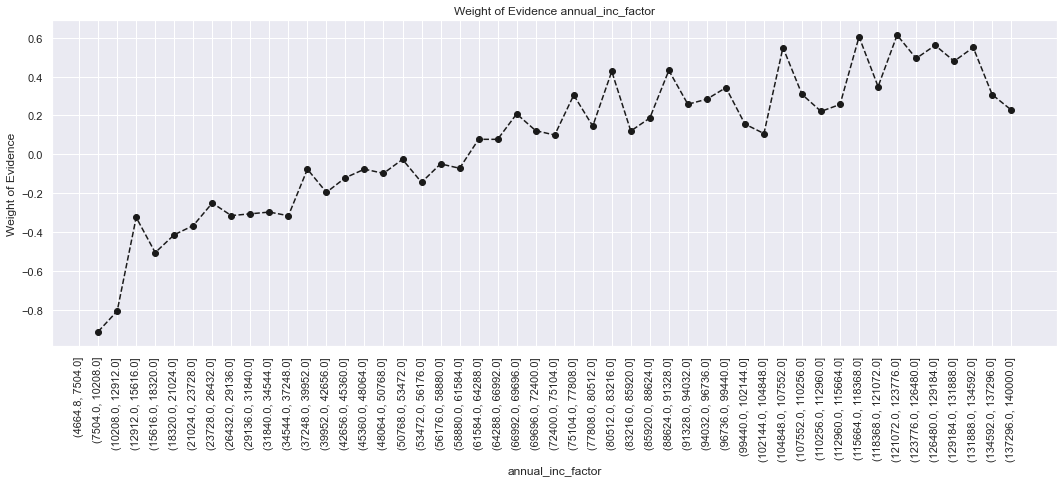

In [367]:
plot_by_woe(df_temp, 90)

In [368]:
# 'annual_inc:<20K', 'annual_inc:20K-30K', 'annual_inc:30K-40K', 'annual_inc:40K-50K', 'annual_inc:50K-60K', 'annual_inc:60K-70K', 'annual_inc:70K-80K', 'annual_inc:80K-90K', 'annual_inc:90K-100K', 'annual_inc:100K-120K', 'annual_inc:120K-140K', 'annual_inc:>140K'
df_inputs_pre['annual_inc:<20K'] = np.where((df_inputs_pre['annual_inc'] < 20000), 1, 0) 
df_inputs_pre['annual_inc:20K-30K'] = np.where((df_inputs_pre['annual_inc'] < 20000) & (df_inputs_pre['annual_inc'] >= 30000), 1, 0) 
df_inputs_pre['annual_inc:30K-40K'] = np.where((df_inputs_pre['annual_inc'] < 30000) & (df_inputs_pre['annual_inc'] >= 40000), 1, 0) 
df_inputs_pre['annual_inc:40K-50K'] = np.where((df_inputs_pre['annual_inc'] < 40000) & (df_inputs_pre['annual_inc'] >= 50000), 1, 0) 
df_inputs_pre['annual_inc:50K-60K'] = np.where((df_inputs_pre['annual_inc'] < 50000) & (df_inputs_pre['annual_inc'] >= 60000), 1, 0) 
df_inputs_pre['annual_inc:60K-70K'] = np.where((df_inputs_pre['annual_inc'] < 60000) & (df_inputs_pre['annual_inc'] >= 70000), 1, 0) 
df_inputs_pre['annual_inc:70K-80K'] = np.where((df_inputs_pre['annual_inc'] < 70000) & (df_inputs_pre['annual_inc'] >= 80000), 1, 0) 
df_inputs_pre['annual_inc:80K-90K'] = np.where((df_inputs_pre['annual_inc'] < 80000) & (df_inputs_pre['annual_inc'] >= 90000), 1, 0) 
df_inputs_pre['annual_inc:90K-100K'] = np.where((df_inputs_pre['annual_inc'] < 90000) & (df_inputs_pre['annual_inc'] >= 100000), 1, 0) 
df_inputs_pre['annual_inc:100K-120K'] = np.where((df_inputs_pre['annual_inc'] < 100000) & (df_inputs_pre['annual_inc'] >= 120000), 1, 0) 
df_inputs_pre['annual_inc:120K-140K'] = np.where((df_inputs_pre['annual_inc'] < 120000) & (df_inputs_pre['annual_inc'] >= 140000), 1, 0) 
df_inputs_pre['annual_inc:>140K'] = np.where((df_inputs_pre['annual_inc'] >= 140000), 1, 0) 

'mths_since_last_delinq'

In [369]:
df_inputs_pre_temp = df_inputs_pre[pd.notnull(df_inputs_pre['mths_since_last_delinq'])]

In [370]:
df_inputs_pre_temp.shape

(43091, 298)

In [371]:
df_inputs_pre.shape

(93257, 298)

In [372]:
df_inputs_pre_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_pre_temp['mths_since_last_delinq'],50)

C:\Users\YizhiZhang\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [373]:
df_temp = woe_ordered_continuous(df_inputs_pre_temp, 'mths_since_last_delinq_factor', df_targets_pre[df_inputs_pre_temp.index])

In [374]:
df_temp

,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.17, 3.4]",1348,0.868694,0.031283,1171.0,177.0,0.030501,0.037668,-0.211036,NaN,NaN,inf
1,"(3.4, 6.8]",1890,0.880423,0.043861,1664.0,226.0,0.043342,0.048095,-0.104055,0.011729,0.106981,inf
2,"(6.8, 10.2]",3373,0.887044,0.078276,2992.0,381.0,0.077933,0.081081,-0.039601,0.006621,0.064453,inf
3,"(10.2, 13.6]",2496,0.895833,0.057924,2236.0,260.0,0.058241,0.055331,0.051263,0.008789,0.090864,inf
4,"(13.6, 17.0]",3165,0.884044,0.073449,2798.0,367.0,0.072880,0.078102,-0.069201,0.011789,0.120464,inf
5,"(17.0, 20.4]",2282,0.893076,0.052958,2038.0,244.0,0.053084,0.051926,0.022057,0.009032,0.091258,inf
6,"(20.4, 23.8]",2115,0.898345,0.049082,1900.0,215.0,0.049489,0.045754,0.078472,0.005269,0.056415,inf
7,"(23.8, 27.2]",2755,0.895463,0.063934,2467.0,288.0,0.064258,0.061290,0.047298,0.002882,0.031174,inf
8,"(27.2, 30.6]",1929,0.896319,0.044766,1729.0,200.0,0.045035,0.042562,0.056482,0.000857,0.009183,inf
9,"(30.6, 34.0]",2453,0.891969,0.056926,2188.0,265.0,0.056991,0.056395,0.010514,0.004350,0.045968,inf


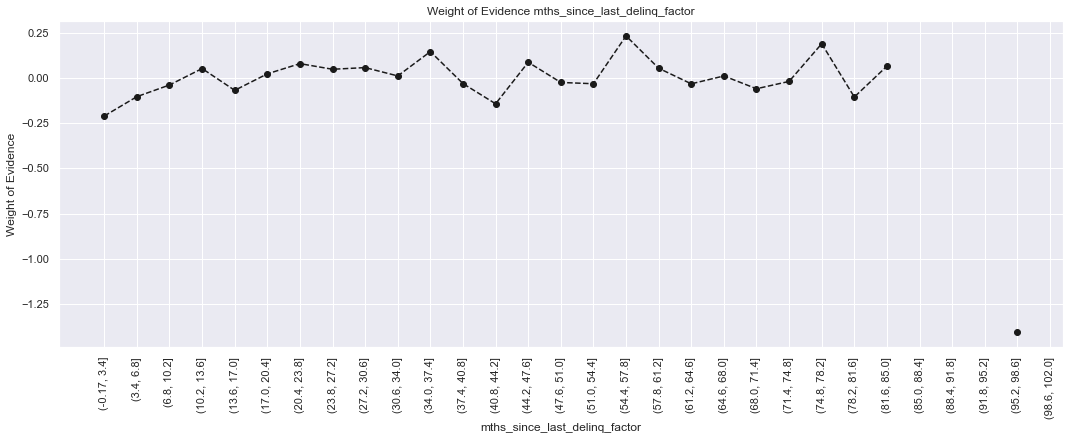

In [375]:
plot_by_woe(df_temp,90)

In [376]:
# 'mths_since_last_delinq:Missing', 'mths_since_last_delinq:0-3', 'mths_since_last_delinq:4-30', 'mths_since_last_delinq:31-56', 'mths_since_last_delinq:>=57'
df_inputs_pre['mths_since_last_delinq:Missing'] = np.where((df_inputs_pre['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_pre['mths_since_last_delinq:0-3'] = np.where((df_inputs_pre['mths_since_last_delinq'] >= 0) & (df_inputs_pre['mths_since_last_delinq'] < 3), 1, 0)
df_inputs_pre['mths_since_last_delinq:4-30'] = np.where((df_inputs_pre['mths_since_last_delinq'] >= 4) & (df_inputs_pre['mths_since_last_delinq'] < 30), 1, 0)
df_inputs_pre['mths_since_last_delinq:31-56'] = np.where((df_inputs_pre['mths_since_last_delinq'] >= 31) & (df_inputs_pre['mths_since_last_delinq'] < 56), 1, 0)
df_inputs_pre['mths_since_last_delinq:>=57'] = np.where((df_inputs_pre['mths_since_last_delinq'] >= 57), 1, 0)

'dti'

In [377]:
df_inputs_pre['dti'].nunique()

3864

In [378]:
df_inputs_pre['dti_factor'] = pd.cut(df_inputs_pre['dti'], 50)

In [379]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'dti_factor', df_targets_pre)
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.04, 0.8]",371,0.886792,0.003978,329.0,42.0,0.003961,0.004122,-0.039853,NaN,NaN,0.032501
1,"(0.8, 1.6]",478,0.899582,0.005126,430.0,48.0,0.005177,0.004711,0.094344,0.012789,0.134196,0.032501
2,"(1.6, 2.399]",639,0.902973,0.006852,577.0,62.0,0.006946,0.006084,0.132467,0.003392,0.038124,0.032501
3,"(2.399, 3.199]",808,0.912129,0.008664,737.0,71.0,0.008872,0.006968,0.241667,0.009155,0.109200,0.032501
4,"(3.199, 3.999]",1047,0.916905,0.011227,960.0,87.0,0.011557,0.008538,0.302785,0.004777,0.061117,0.032501
5,"(3.999, 4.799]",1260,0.912698,0.013511,1150.0,110.0,0.013844,0.010795,0.248796,0.004207,0.053988,0.032501
6,"(4.799, 5.599]",1527,0.912901,0.016374,1394.0,133.0,0.016782,0.013052,0.251343,0.000203,0.002547,0.032501
7,"(5.599, 6.398]",1730,0.905202,0.018551,1566.0,164.0,0.018852,0.016094,0.158173,0.007699,0.093170,0.032501
8,"(6.398, 7.198]",1999,0.919960,0.021435,1839.0,160.0,0.022139,0.015702,0.343563,0.014758,0.185390,0.032501
9,"(7.198, 7.998]",2227,0.908846,0.023880,2024.0,203.0,0.024366,0.019921,0.201384,0.011114,0.142178,0.032501


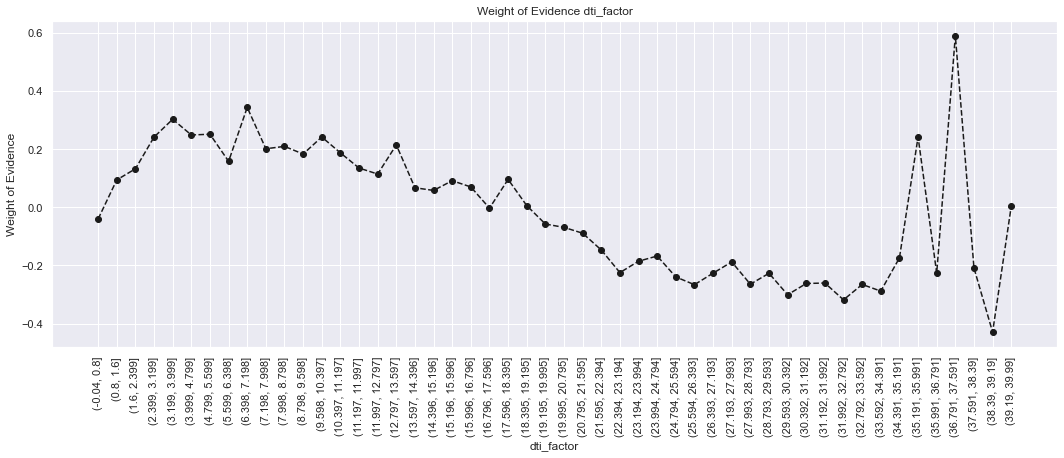

In [380]:
plot_by_woe(df_temp,90)

In [381]:
# 'dti:<4', 'dti:4-8', 'dti:8-12', 'dti:12-13.6', 'dti:13.6-16.8', 'dti:16.8-20.8', 'dti:20.8-24', 'dti:24-28', 'dti:>28'

df_inputs_pre['dti:<4'] = np.where((df_inputs_pre['dti'] < 4), 1, 0)

df_inputs_pre['dti:4-8'] = np.where((df_inputs_pre['dti'] >= 4) & (df_inputs_pre['dti'] < 8), 1, 0)

df_inputs_pre['dti:8-12'] = np.where((df_inputs_pre['dti'] >= 8) & (df_inputs_pre['dti'] < 12), 1, 0)

df_inputs_pre['dti:12-13.6'] = np.where((df_inputs_pre['dti'] >= 12) & (df_inputs_pre['dti'] < 13.6), 1, 0)

df_inputs_pre['dti:13.6-16.8'] = np.where((df_inputs_pre['dti'] >= 13.6) & (df_inputs_pre['dti'] < 16.8), 1, 0)

df_inputs_pre['dti:16.8-20.8'] = np.where((df_inputs_pre['dti'] >= 16.8) & (df_inputs_pre['dti'] < 20.8), 1, 0)

df_inputs_pre['dti:20.8-24'] = np.where((df_inputs_pre['dti'] >= 20.8) & (df_inputs_pre['dti'] < 24), 1, 0)

df_inputs_pre['dti:24-28'] = np.where((df_inputs_pre['dti'] >= 24) & (df_inputs_pre['dti'] < 28), 1, 0)

df_inputs_pre['dti:>28'] = np.where((df_inputs_pre['dti'] >= 28), 1, 0)

'mths_since_last_record'

In [382]:
df_inputs_pre['mths_since_last_record'].describe()

count    12571.000000
mean        74.411025
std         30.251104
min          0.000000
25%         53.000000
50%         77.000000
75%        102.000000
max        129.000000
Name: mths_since_last_record, dtype: float64

In [383]:
df_inputs_pre['mths_since_last_record'].isnull().sum()

80686

In [384]:
X_train.shape

(373028, 323)

In [385]:
pd.options.display.max_rows = 100

In [386]:
df_inputs_pre['mths_since_last_record_factor'] = pd.cut(df_inputs_pre['mths_since_last_record'], 50)

In [387]:
df_temp = woe_ordered_continuous(df_inputs_pre, 'mths_since_last_record_factor', df_targets_pre)

C:\Users\YizhiZhang\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [388]:
df_temp

,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.129, 2.58]",244,0.741803,0.019410,181.0,63.0,0.016036,0.049065,-1.118309,NaN,NaN,inf
1,"(2.58, 5.16]",36,0.888889,0.002864,32.0,4.0,0.002835,0.003115,-0.094230,0.147086,1.024079,inf
2,"(5.16, 7.74]",39,0.923077,0.003102,36.0,3.0,0.003190,0.002336,0.311235,0.034188,0.405465,inf
3,"(7.74, 10.32]",66,0.939394,0.005250,62.0,4.0,0.005493,0.003115,0.567169,0.016317,0.255933,inf
4,"(10.32, 12.9]",42,0.833333,0.003341,35.0,7.0,0.003101,0.005452,-0.564234,0.106061,1.131402,inf
5,"(12.9, 15.48]",69,0.869565,0.005489,60.0,9.0,0.005316,0.007009,-0.276551,0.036232,0.287682,inf
6,"(15.48, 18.06]",95,0.863158,0.007557,82.0,13.0,0.007265,0.010125,-0.331902,0.006407,0.055350,inf
7,"(18.06, 20.64]",58,0.965517,0.004614,56.0,2.0,0.004961,0.001558,1.158533,0.102359,1.490435,inf
8,"(20.64, 23.22]",101,0.891089,0.008034,90.0,11.0,0.007974,0.008567,-0.071757,0.074428,1.230290,inf
9,"(23.22, 25.8]",94,0.946809,0.007478,89.0,5.0,0.007885,0.003894,0.705527,0.055719,0.777284,inf


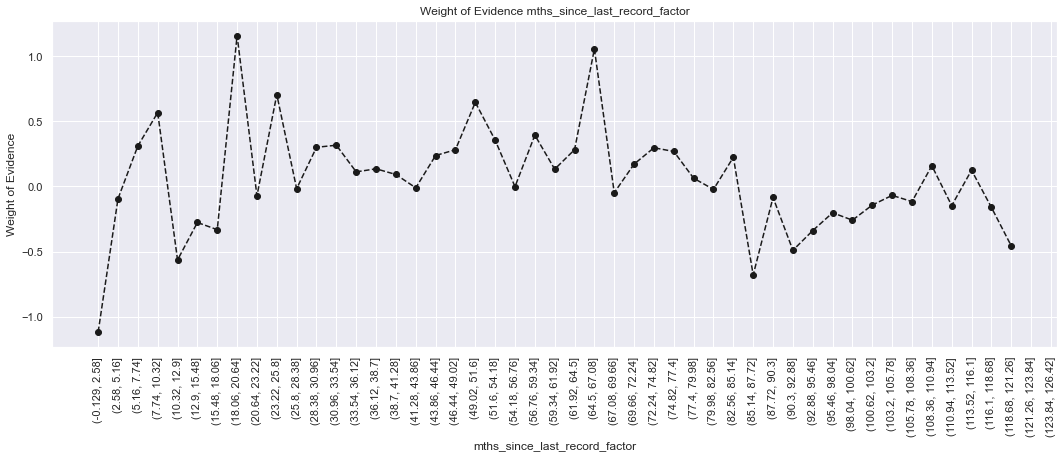

In [389]:
plot_by_woe(df_temp,90)

In [390]:
# 'mths_since_last_record:Missing','mths_since_last_record:0-4.8','mths_since_last_record:4.8-24.2','mths_since_last_record:24.2-36.3','mths_since_last_record:36.3-50.8','mths_since_last_record:50.8-67.8','mths_since_last_record:67.8-80','mths_since_last_record:80-84.7', 'mths_since_last_record:>84.7'

df_inputs_pre['mths_since_last_record:Missing'] = np.where((df_inputs_pre['mths_since_last_record'].isnull()), 1, 0)

df_inputs_pre['mths_since_last_record:0-4.8'] = np.where((df_inputs_pre['mths_since_last_record'] < 4.8), 1, 0)

df_inputs_pre['mths_since_last_record:4.8-24.2'] = np.where((df_inputs_pre['mths_since_last_record'] >= 4.8) & (df_inputs_pre['mths_since_last_record'] < 24.2), 1, 0)

df_inputs_pre['mths_since_last_record:24.2-36.3'] = np.where((df_inputs_pre['mths_since_last_record'] >= 24.2) & (df_inputs_pre['mths_since_last_record'] < 36.3), 1, 0)

df_inputs_pre['mths_since_last_record:36.3-50.8'] = np.where((df_inputs_pre['mths_since_last_record'] >= 36.3) & (df_inputs_pre['mths_since_last_record'] < 50.8), 1, 0)

df_inputs_pre['mths_since_last_record:50.8-67.8'] = np.where((df_inputs_pre['mths_since_last_record'] >= 50.8) & (df_inputs_pre['mths_since_last_record'] < 67.8), 1, 0)

df_inputs_pre['mths_since_last_record:67.8-80'] = np.where((df_inputs_pre['mths_since_last_record'] >= 67.8) & (df_inputs_pre['mths_since_last_record'] < 80), 1, 0)

df_inputs_pre['mths_since_last_record:80-84.7'] = np.where((df_inputs_pre['mths_since_last_record'] >= 80) & (df_inputs_pre['mths_since_last_record'] < 84.7), 1, 0)

df_inputs_pre['mths_since_last_record:>84.7'] = np.where((df_inputs_pre['mths_since_last_record'] >= 84.7), 1, 0)

In [237]:
df_inputs_pre.shape

(373028, 323)

In [391]:
df_inputs_pre.shape

(93257, 323)

### save precessed data to X_train

In [238]:
inputs_train = df_inputs_pre

## Preprocessing the Test Dataset

change from
df_inputs_pre = X_train
df_targets_pre = y_train

to
df_inputs_pre = Xtest
df_targets_pre = y_test

rerun the above section

In [392]:
inputs_test = df_inputs_pre

In [393]:
inputs_train.to_csv('loan_data_inputs_train.csv')
y_train.to_csv('loan_data_targets_train.csv')
inputs_test.to_csv('loan_data_inputs_test.csv')
y_test.to_csv('loan_data_targets_test.csv')

# modeling

In [3]:
inputs_train = pd.read_csv('loan_data_inputs_train.csv', index_col=0)
targets_train = pd.read_csv('loan_data_targets_train.csv', index_col=0)
# , header=None)
inputs_test = pd.read_csv('loan_data_inputs_test.csv', index_col=0)
targets_test = pd.read_csv('loan_data_targets_test.csv', index_col=0) 
#, header=None)

In [395]:
inputs_train.head()

,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,term_int,earliest_cr_line_date,mths_since_earliest_cr_line,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:WV_NH_WY_DC_ME_ID,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,purpose:smabus_edu_mov_hou_oth,purpose:reen_med_wed_vac,purpose:hom_maj_car,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d_factor,mths_since_issue_d::<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate_factor,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.75-20.281,int_rate:>20.281,funded_amnt_factor,mths_since_earliest_cr_line_factor,m

In [4]:
inputs_train.shape

(373028, 323)

In [398]:
type(targets_train)

pandas.core.frame.DataFrame

In [6]:
targets_train.shape

(373028, 1)

In [7]:
inputs_test.shape

(93257, 323)

In [8]:
targets_test.shape

(93257, 1)

In [9]:
inputs_train_ref = inputs_train.loc[:, [
     'grade:A', 
 'grade:B', 
 'grade:C', 
 'grade:D', 
 'grade:E', 
 'grade:F', 
 'grade:G', 
 'home_ownership:RENT_OTHER_NONE_ANY', 
 'home_ownership:OWN', 
 'home_ownership:MORTGAGE', 
 'addr_state:ND_NE_IA_NV_FL_HI_AL', 
 'addr_state:WV_NH_WY_DC_ME_ID', 
 'addr_state:NM_VA', 
 'addr_state:NY', 
 'addr_state:OK_TN_MO_LA_MD_NC', 
 'addr_state:CA', 
 'addr_state:UT_KY_AZ_NJ', 
 'addr_state:AR_MI_PA_OH_MN', 
 'addr_state:RI_MA_DE_SD_IN', 
 'addr_state:GA_WA_OR', 
 'addr_state:WI_MT', 
 'addr_state:IL_CT', 
 'addr_state:KS_SC_CO_VT_AK_MS', 
 'purpose:smabus_edu_mov_hou_oth', 
 'purpose:reen_med_wed_vac', 
 'purpose:debt_consolidation', 
 'purpose:hom_maj_car', 
 'purpose:credit_card', 
 'verification_status:Not Verified', 
 'verification_status:Source Verified', 
 'verification_status:Verified', 
 'initial_list_status:f', 
 'initial_list_status:w', 
 'term:36', 
 'term:60', 
 'emp_length:0', 
 'emp_length:1', 
 'emp_length:2-4', 
 'emp_length:5-6', 
 'emp_length:7-9', 
 'emp_length:10', 
 'int_rate:<9.548', 
 'int_rate:9.548-12.025', 
 'int_rate:12.025-15.74', 
 'int_rate:15.75-20.281', 
 'int_rate:>20.281', 
 'annual_inc:<20K', 
 'annual_inc:20K-30K', 
 'annual_inc:30K-40K', 
 'annual_inc:40K-50K', 
 'annual_inc:50K-60K', 
 'annual_inc:60K-70K', 
 'annual_inc:70K-80K', 
 'annual_inc:80K-90K', 
 'annual_inc:90K-100K', 
 'annual_inc:100K-120K', 
 'annual_inc:120K-140K', 
 'annual_inc:>140K', 
 'mths_since_last_delinq:Missing', 
 'mths_since_last_delinq:0-3', 
 'mths_since_last_delinq:4-30', 
 'mths_since_last_delinq:>=57', 
 'mths_since_last_delinq:31-56', 
 'mths_since_issue_d::<38', 
 'mths_since_issue_d:38-39', 
 'mths_since_issue_d:40-41', 
 'mths_since_issue_d:42-48', 
 'mths_since_issue_d:49-52', 
 'mths_since_issue_d:53-64', 
 'mths_since_issue_d:65-84', 
 'mths_since_issue_d:>84', 
 'mths_since_earliest_cr_line:<140', 
 'mths_since_earliest_cr_line:141-164', 
 'mths_since_earliest_cr_line:165-247', 
 'mths_since_earliest_cr_line:248-270', 
 'mths_since_earliest_cr_line:271-352', 
 'mths_since_earliest_cr_line:>352', 
 'delinq_2yrs:0', 
 'delinq_2yrs:1-3', 
 'delinq_2yrs:>=4', 
 'inq_last_6mths:0', 
 'inq_last_6mths:1-2', 
 'inq_last_6mths:3-6', 
 'inq_last_6mths:>6', 
 'open_acc:0', 
 'open_acc:1-3', 
 'open_acc:4-12', 
 'open_acc:13-22', 
 'open_acc:23-25', 
 'open_acc:26-30', 
 'open_acc:>30', 
 'pub_rec:0', 
 'pub_rec:1-2', 
 'pub_rec:3-6', 
 'pub_rec:>6', 
 'total_acc:<=9', 
 'total_acc:10-21', 
 'total_acc:22-33', 
 'total_acc:34-51', 
 'total_acc:>51', 
 'acc_now_delinq:0', 
 'acc_now_delinq:>=1', 
 'total_rev_hi_lim:<36K', 
 'total_rev_hi_lim:36K-56K', 
 'total_rev_hi_lim:56K-92K', 
 'total_rev_hi_lim:>92K', 
 'dti:<4', 
 'dti:4-8', 
 'dti:8-12', 
 'dti:12-13.6', 
 'dti:13.6-16.8', 
 'dti:16.8-20.8', 
 'dti:20.8-24', 
 'dti:24-28', 
 'dti:>28', 
 'mths_since_last_record:Missing', 
 'mths_since_last_record:0-4.8', 
 'mths_since_last_record:4.8-24.2', 
 'mths_since_last_record:24.2-36.3', 
 'mths_since_last_record:36.3-50.8', 
 'mths_since_last_record:50.8-67.8', 
 'mths_since_last_record:67.8-80', 
 'mths_since_last_record:80-84.7', 
 'mths_since_last_record:>84.7'
]]

In [10]:
ref_catogoies = [  
 'grade:G', 
 'home_ownership:RENT_OTHER_NONE_ANY', 
 'addr_state:ND_NE_IA_NV_FL_HI_AL', 
 'purpose:smabus_edu_mov_hou_oth', 
 'verification_status:Verified', 
 'initial_list_status:f', 
 'term:60', 
 'emp_length:0', 
 'int_rate:>20.281', 
 'annual_inc:<20K', 
 'mths_since_last_delinq:0-3', 
 'mths_since_issue_d:>84', 
 'mths_since_earliest_cr_line:<140', 
 'delinq_2yrs:>=4', 
 'inq_last_6mths:>6', 
 'open_acc:0', 
 'pub_rec:0', 
 'total_acc:<=9', 
 'acc_now_delinq:0', 
 'total_rev_hi_lim:<36K', 
 'dti:>28', 
 'mths_since_last_record:0-4.8'
]

In [11]:
X_train = inputs_train_ref.drop(ref_catogoies, axis=1)

In [12]:
X_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:WV_NH_WY_DC_ME_ID,addr_state:NM_VA,...,dti:20.8-24,dti:24-28,mths_since_last_record:Missing,mths_since_last_record:4.8-24.2,mths_since_last_record:24.2-36.3,mths_since_last_record:36.3-50.8,mths_since_last_record:50.8-67.8,mths_since_last_record:67.8-80,mths_since_last_record:80-84.7,mths_since_last_record:>84.7
427211,1,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
206088,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
136020,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
412305,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
36159,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0


In [13]:
X_train.shape

(373028, 102)

In [14]:
y_train = targets_train.values.ravel()

In [15]:
y_train.shape

(373028,)

## fit the model

In [16]:
reg = LogisticRegression(max_iter=1000)

In [17]:
reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [18]:
reg.intercept_

array([-1.15727248])

In [19]:
reg.coef_

array([[ 1.08862868,  0.8553078 ,  0.65613321,  0.4732969 ,  0.29952263,
         0.12207385,  0.08372209,  0.16182948,  0.43841404, -0.03527229,
        -0.02138825, -0.03822759, -0.00366641, -0.00993561,  0.02072111,
         0.00316694,  0.09198587,  0.11137968,  0.17106844,  0.22265595,
         0.20964439,  0.1111934 ,  0.17784931,  0.21036663,  0.05427261,
        -0.01699878,  0.05330716,  0.05017021,  0.13370664,  0.16555838,
         0.13244268,  0.10638763,  0.18387532,  0.89328168,  0.55229877,
         0.29808128,  0.10369277,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.1944887 , -0.01392522,  0.08428828,
         0.02719035,  0.08014377,  1.07652233,  0.87896795,  0.78444294,
         0.58200806,  0.41851385,  0.17290118, -0.06608849,  0.06607263,
         0.07884967,  0.13335141,  0.1807176 , -0.16717217,  0.097566  ,
         0.04434717,  0.68242348,  0.54414372,  0.3

In [20]:
feature_name = X_train.columns.values

In [21]:
summary_table = pd.DataFrame(columns=['Feature Name'], data= feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table.head()

,Feature Name,Coefficients
0,Intercept,-1.157272
1,grade:A,1.088629
2,grade:B,0.855308
3,grade:C,0.656133
4,grade:D,0.473297


# Build a model p-values

In [34]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs)
        
    def fit(self, X, y):
        self.model.fit(X, y)
        demon = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        demon = np.tile(demon, (X.shape[1],1)).T
        F_ij = np.dot((X / demon).T, X) + 0.001
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [35]:
reg = LogisticRegression_with_p_values(max_iter=1000)

In [36]:
reg.fit(X_train, y_train)

LinAlgError: Singular matrix